# Iteration 1 - Data Understanding

> **Creator**: Shirel & Alex

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
import scipy.stats as stats
import itertools
from tqdm import tqdm
import pandas as pd

## Functions

### Loading images 

In [2]:
def load_images_from_folder(folder_path, extensions=('.png', '.jpg', '.jpeg', '.JPG')):
    """
    Load all image file paths from a specified folder that match the given file extensions.

    Parameters:
    folder_path (str): The path to the folder containing the images.
    extensions (tuple of str): A tuple of file extensions to filter the images by. 
                               Default is ('.png', '.jpg', '.jpeg', '.JPG').

    Returns:
    list: A list of full file paths to images in the folder that match the specified extensions.
    
    Raises:
    FileNotFoundError: If the specified folder does not exist.
    """

    # Check if the folder exists
    if not os.path.exists(folder_path):
        raise FileNotFoundError(f"The specified folder does not exist: {folder_path}")

    # List comprehension to gather all image paths with the specified extensions
    image_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(extensions)]

    return image_paths

In [3]:
def load_and_preprocess_images(image_paths, resize_dim=(256, 256)):
    images = []

    # Initialize tqdm progress bar
    for path in tqdm(image_paths, desc="Loading and preprocessing images", unit="image"):
        img = cv2.imread(path)
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
        img_resized = cv2.resize(img_gray, resize_dim)  # Resize for consistency
        images.append(img_resized)

    return images

In [4]:
def load_images(image_paths):
    original_images = []
    for path in image_paths:
        img = cv2.imread(path)  # Load original image
        original_images.append(img)
    return original_images

### Statistical Analysis

Functions to calculate the characteristics of each of the images

#### Brightness

In [5]:
def calculate_brightness(image):
    return np.mean(image)  # Mean pixel intensity

#### Sharpness

In [6]:
def calculate_sharpness(image):
    # Sharpness based on the variance of the Laplacian
    return cv2.Laplacian(image, cv2.CV_64F).var()  # Variance of Laplacian method

#### Contrast

In [7]:
def calculate_contrast(image):
    return image.std()  # Standard deviation of pixel values

#### Noise

In [8]:
def calculate_noise(image):
    # Convert to grayscale if it's not
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply a Gaussian blur to the image
    blurred = cv2.GaussianBlur(image, (3, 3), 0)

    # Calculate the difference between the original and blurred image
    noise = cv2.absdiff(image, blurred)

    # Return the variance of the noise image (higher variance = more noise)
    return np.var(noise)

#### Skew

In [9]:
def calculate_skew(image):
    # Check if the image is 2D (grayscale)
    if len(image.shape) != 2:
        raise ValueError("Invalid image format. Image must be a 2D grayscale image.")

    # Apply thresholding to get a binary image
    _, binary = cv2.threshold(image, 150, 255, cv2.THRESH_BINARY_INV)

    # Find contours of the binary image
    coords = np.column_stack(np.where(binary > 0))

    if coords.size == 0:  # Check if there are any coordinates found
        return 0  # If no contours found, return 0 as skew

    # Calculate the minimum area rectangle angle
    angle = cv2.minAreaRect(coords)[-1]

    # Adjust angle
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle

    # Round small angles to zero
    if abs(angle) < 1e-2:  # If the angle is extremely small (close to 0)
        angle = 0

    return round(angle, 2)  # Round the angle to two decimal places

#### Line Spacing

In [10]:
def calculate_line_spacing(image):
    # Check if the image is 2D (grayscale)
    if len(image.shape) != 2:
        raise ValueError("Invalid image format. Image must be a 2D grayscale image.")
    
    _, binary = cv2.threshold(image, 150, 255, cv2.THRESH_BINARY_INV)

    # Find contours to get bounding boxes of text lines
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    heights = []

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        heights.append(h)

    # Calculate average spacing based on the heights of bounding boxes
    if len(heights) > 1:
        line_spacing = np.mean(np.diff(sorted(heights)))
    else:
        line_spacing = 0  # No lines found

    return line_spacing

#### Tables Detected

In [11]:
def detect_tables(image):
    # Check if the image is 2D (grayscale)
    if len(image.shape) != 2:
        raise ValueError("Invalid image format. Image must be a 2D grayscale image.")
    _, binary = cv2.threshold(image, 150, 255, cv2.THRESH_BINARY_INV)
    
    binary = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, 11, 2)

    # Find contours that could represent tables
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    table_contours = []

    for contour in contours:
        # Filter contours by area to identify potential tables
        if cv2.contourArea(contour) > 1000:  # Threshold for minimum area
            table_contours.append(contour)

    return len(table_contours)  # Return the number of detected tables


#### Resolution

In [12]:
# Function to calculate image resolution
def calculate_resolution(image):
    height, width = image.shape[:2]  # Get dimensions of the image
    return height * width  # Return the total number of pixels

#### Elements Detected

In [13]:
# Function to calculate Detected Elements (simple heuristic)
def calculate_elements_detection(image):
    # Check if the image is 2D (grayscale)
    if len(image.shape) != 2:
        raise ValueError("Invalid image format. Image must be a 2D grayscale image.")
    
    _, binary = cv2.threshold(image, 150, 255, cv2.THRESH_BINARY_INV)

    # Find contours to identify the alignment of tables and text
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Calculate the alignment based on the bounding box of the contours
    alignments = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        alignments.append((x, y, w, h))

    # Here, you can develop a more sophisticated measure for alignment if needed
    return len(alignments)  # Return number of detected bounding boxes as a simple measure

#### Texture

In [14]:
# Function to calculate texture using local variation (Laplacian)
def calculate_texture(image):
    laplacian = cv2.Laplacian(image, cv2.CV_64F)  # Apply Laplacian filter
    return laplacian.std()  # Standard deviation of the Laplacian as a measure of texture complexity

#### Patterns

In [15]:
# Function to calculate patterns (simple edge detection to find patterns)
def calculate_patterns(image):
    # Check if the image is 2D (grayscale)
    if len(image.shape) != 2:
        raise ValueError("Invalid image format. Image must be a 2D grayscale image.")
    edges = cv2.Canny(image, 100, 200)  # Edge detection
    return np.sum(edges > 0)  # Count the number of edge pixels as a measure of patterns

### Statistical Summary

This function provides summary statistics for all images based on brightness, sharpness, and contrast.

In [16]:
def image_statistics_table(images):
    stats_data = {'Image': [], 
                  'Brightness': [], 
                  'Sharpness': [], 
                  'Contrast': [],
                  'Noise': [],
                  'Skew': [],
                  'Line Spacing': [],
                  'Tables Detected': [],
                  'Resolution': [],
                  'Detected Elements': [],
                  'Texture': [],
                  'Patterns': []}

    for i, img in enumerate(images):
        stats_data['Image'].append(f'Image_{i+1}')
        stats_data['Brightness'].append(calculate_brightness(img))
        stats_data['Sharpness'].append(calculate_sharpness(img))
        stats_data['Contrast'].append(calculate_contrast(img))
        stats_data['Noise'].append(calculate_noise(img))
        stats_data['Skew'].append(calculate_skew(img))
        stats_data['Line Spacing'].append(calculate_line_spacing(img))
        stats_data['Tables Detected'].append(detect_tables(img))
        stats_data['Resolution'].append(calculate_resolution(img))
        stats_data['Detected Elements'].append(calculate_elements_detection(img))
        stats_data['Texture'].append(calculate_texture(img))
        stats_data['Patterns'].append(calculate_patterns(img))
    # Create a DataFrame to store per-image statistics
    df = pd.DataFrame(stats_data)
    return df

In [17]:
# Function to calculate overall statistical summary as a table
def overall_statistical_summary(df):
    # Calculate the summary for Brightness, Sharpness, and Contrast
    summary_df = df[['Brightness', 'Sharpness', 'Contrast','Noise','Skew','Line Spacing', 'Tables Detected','Resolution',
                 'Detected Elements','Texture','Patterns']].describe()

    # Return the summary table
    return summary_df

### Visualizations

#### General functions

In [18]:
# Function for visualizing histograms and other distributions
def plot_characteristic_distribution(df, characteristic, unit, plot_type='hist'):
    plt.figure(figsize=(10, 6))

    if plot_type == 'hist':
        sns.histplot(df[characteristic], kde=True, bins=30, color='blue')
    elif plot_type == 'box':
        sns.boxplot(x=df[characteristic], color='green')

    plt.title(f"Distribution of {characteristic}")
    plt.xlabel(f"{characteristic} ({unit})")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

#### Relationships

In [19]:
# Function to plot relationships (scatter plots) between two characteristics
def plot_characteristic_relationship(df, characteristic_1, characteristic_2, unit_1, unit_2, use_color=False):
    plt.figure(figsize=(10, 6))

    if use_color:
        sns.scatterplot(x=df[characteristic_1], y=df[characteristic_2], hue=df[characteristic_2], palette='coolwarm', s=50)
    else:
        sns.scatterplot(x=df[characteristic_1], y=df[characteristic_2], s=50)

    plt.title(f"Relationship between {characteristic_1} and {characteristic_2}")
    plt.xlabel(f"{characteristic_1} ({unit_1})")
    plt.ylabel(f"{characteristic_2} ({unit_2})")
    plt.grid(True)
    plt.show()


In [20]:
# Function to create a heatmap for correlations between characteristics
def plot_correlation_heatmap(df, characteristics, characteristic_units):
    plt.figure(figsize=(10, 8))  # Increase figure size for better visibility
    correlation_matrix = df[characteristics].corr()

    # Create annotations with correlation values and units
    annot = correlation_matrix.round(2).astype(str)  # Round and convert to string
    for i in range(len(characteristics)):
        for j in range(len(characteristics)):
            annot.iloc[i, j] += f"\n({characteristic_units[j]})"  # Append units

    # Create the heatmap
    sns.heatmap(correlation_matrix, annot=annot, cmap='coolwarm', linewidths=0.5, fmt='',
                cbar_kws={'shrink': 0.8}, annot_kws={"size": 10})  # Font size for annotations

    plt.title("Correlation Heatmap Between Characteristics", fontsize=16)
    plt.xlabel("Characteristics (Unit)", fontsize=14)
    plt.ylabel("Characteristics (Unit)", fontsize=14)

    # Set tick labels with adjusted font size
    plt.xticks(ticks=range(len(characteristics)),
               labels=[f"{char} ({unit})" for char, unit in zip(characteristics, characteristic_units)],
               rotation=45, fontsize=12)
    plt.yticks(ticks=range(len(characteristics)),
               labels=[f"{char} ({unit})" for char, unit in zip(characteristics, characteristic_units)],
               rotation=0, fontsize=12)

    plt.tight_layout()  # Adjust layout to prevent clipping
    plt.show()

### Statistical Tests

In [21]:
# Flexible Statistical Test Function
def overall_statistical_tests(df):
    # Create a DataFrame to store statistical test results
    test_results = {'Test': [], 'Characteristic_1': [], 'Characteristic_2': [], 'Statistic': [], 'P-Value': []}

    # Perform normality tests for each characteristic
    for col in ['Brightness', 'Sharpness', 'Contrast']:
        stat, p_value = stats.normaltest(df[col])
        test_results['Test'].append('Normality')
        test_results['Characteristic_1'].append(col)
        test_results['Characteristic_2'].append(None)  # No second characteristic for univariate tests
        test_results['Statistic'].append(stat)
        test_results['P-Value'].append(p_value)

    # Perform Pearson correlation tests between each pair of characteristics
    pairs = itertools.combinations(['Brightness', 'Sharpness', 'Contrast','Noise','Skew','Line Spacing', 'Tables Detected','Resolution','Detected Elements','Texture','Patterns'], 2)
    for char1, char2 in pairs:
        corr_stat, corr_p_val = stats.pearsonr(df[char1], df[char2])
        test_results['Test'].append('Pearson Correlation')
        test_results['Characteristic_1'].append(char1)
        test_results['Characteristic_2'].append(char2)
        test_results['Statistic'].append(corr_stat)
        test_results['P-Value'].append(corr_p_val)

    # Return the test results as a DataFrame
    return pd.DataFrame(test_results)


## Executing the Data Analysis

In [22]:
# Define the path to the folder containing the images to be processed
folder_path = '../data/original'  # Update this path to point to your specific folder containing images

In [23]:
image_paths = load_images_from_folder(folder_path)

### Step 1: Load and preprocess images

In [24]:
images = load_and_preprocess_images(image_paths)

Loading and preprocessing images: 100%|██████████| 696/696 [02:29<00:00,  4.64image/s]


### Step 2: Create image statistics table

In [25]:
df_stats = image_statistics_table(images)
print("Image Statistics Table:")
df_stats
#df_stats.head()

Image Statistics Table:


Image  Brightness    Sharpness   Contrast      Noise  Skew  \
0      Image_1  100.235352   461.111981  46.517143  16.481575 -90.0   
1      Image_2  111.792526   469.891161  58.305669  19.017923 -90.0   
2      Image_3  101.166916   546.359099  46.334832  17.228624 -90.0   
3      Image_4  105.133728   440.219981  45.781777  14.545720 -90.0   
4      Image_5   99.903900   455.694386  49.250150  15.851454 -90.0   
..         ...         ...          ...        ...        ...   ...   
691  Image_692  101.516571  1833.431923  40.417352  58.062694   0.0   
692  Image_693  106.385941  1041.116323  37.990654  44.667209 -90.0   
693  Image_694   88.540466  1367.574228  28.928935  50.442838 -90.0   
694  Image_695   88.097198  2407.847885  27.565080  78.062187 -90.0   
695  Image_696   78.755615   887.212345  23.310665  32.030755 -90.0   

     Line Spacing  Tables Detected  Resolution  Detected Elements    Texture  \
0        0.000000                2       65536                  1  21.473518   
1       63.750000                1       65536                  5  21.676973   
2        0.000000                1       65536                  1  23.374326   
3        0.000000                1       65536                  1  20.981420   
4        0.000000                0       65536                  1  21.346999   
..            ...              ...         ...                ...        ...   
691      8.500000                1       65536                 31  42.818593   
692      4.473684                1       65536                 58  32.266334   
693     42.500000                1       65536                  7  36.980728   
694      0.000000                2       65536                  1  49.069827   
695      0.000000                1       65536                  1  29.786110   

     Patterns  
0        2327  
1        2119  
2        1818  
3        1705  
4        1595  
..        ...  
691      5033  
692      3173  
693      4398  
694      7452  
695      3589  

[696 rows x 12 columns]

#### Explenation about the different characteristics and how they are measured:
- Brightness represents the overall intensity of light in an image. It is measured by calculating the mean (average) pixel value across the image.
    - Units: Pixel intensity values, typically on a scale of 0 to 255 in an 8-bit grayscale image. 0 means completely black. 255 means completely white. 
    - Values in between represent varying levels of gray. For example, a brightness value of 128 would indicate an image that is midway between black and white (medium gray).
- Contrast refers to the difference between the darkest and brightest parts of an image. It is often measured by calculating the standard deviation of pixel values in the image. The standard deviation tells us how much the pixel values are spread out (the higher the contrast, the wider the spread between bright and dark areas).
    - Units: The unit is the pixel standard deviation (the spread of pixel intensity values). It reflects how much variation exists in the pixel intensity values. 
        - A low contrast image would have values close together (e.g., most pixels around a middle gray). 
        - A high contrast image would have pixel values widely spread (e.g., a mix of very dark and very bright areas).
- Sharpness measures how clear or well-defined the edges are in an image. It is calculated using the variance of the Laplacian (a method that highlights the edges in the image). The variance measures how much the values deviate from the average, with higher variance meaning sharper images.
    - Units: The unit here is a sharpness index, specifically the variance of the Laplacian, which is a numerical value that reflects how sharp the image is. Like contrast, it doesn’t have a traditional unit but represents how much the pixel values at edges vary.
        - A higher value means the image is sharper, with clearer edges.
        - A lower value means the image is blurrier or has fewer defined edges.

### Step 3: Overall statistical summary

In [26]:
overall_summary = overall_statistical_summary(df_stats)
print("Overall Statistical Summary:")
overall_summary

Overall Statistical Summary:


Brightness    Sharpness    Contrast       Noise        Skew  \
count  696.000000   696.000000  696.000000  696.000000  696.000000   
mean   105.846462  1067.880667   44.120776   35.355692  -82.887931   
std      6.999411   558.043095    6.247035   16.921546   24.297179   
min     78.755615   289.718353   23.310665   10.857074  -90.000000   
25%    101.728306   643.550028   39.350161   22.419044  -90.000000   
50%    105.736992   907.495669   44.142917   30.954195  -90.000000   
75%    108.909061  1364.361567   48.094967   45.262423  -90.000000   
max    164.801010  2940.218489   76.862816   91.285207    0.000000   

       Line Spacing  Tables Detected  Resolution  Detected Elements  \
count    696.000000       696.000000       696.0         696.000000   
mean       6.544738         1.705460     65536.0          38.581897   
std       28.124769         0.657682         0.0          50.087655   
min        0.000000         0.000000     65536.0           1.000000   
25%        0.000000         1.000000     65536.0           1.000000   
50%        1.424759         2.000000     65536.0           3.000000   
75%        4.180328         2.000000     65536.0          64.000000   
max      255.000000         4.000000     65536.0         297.000000   

          Texture     Patterns  
count  696.000000   696.000000  
mean    31.644388  3764.093391  
std      8.161440  1253.966943  
min     17.021115  1477.000000  
25%     25.368284  2744.250000  
50%     30.124668  3520.000000  
75%     36.937257  4633.500000  
max     54.223782  7452.000000

### Step 4: Visualize overall distributions

In [27]:
# Define characteristics and their units in a single dictionary
characteristics_units = {
    'Brightness': 'Pixel Value (0-255)',
    'Contrast': 'Pixel Value (0-255) Std Dev',
    'Sharpness': 'Pixel Intensity Squared Variability',
    'Noise': 'Pixel Value (0-255) Std Dev',
    'Skew': 'Degrees (°)',
    'Line Spacing': 'Pixel Count Avg',
    'Tables Detected': 'Count',
    'Resolution': 'Pixel Count',
    'Detected Elements': 'Count',
    'Texture': 'Pixel Intensity Variability',
    'Patterns': 'Count'
}

d:\Software\Python\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


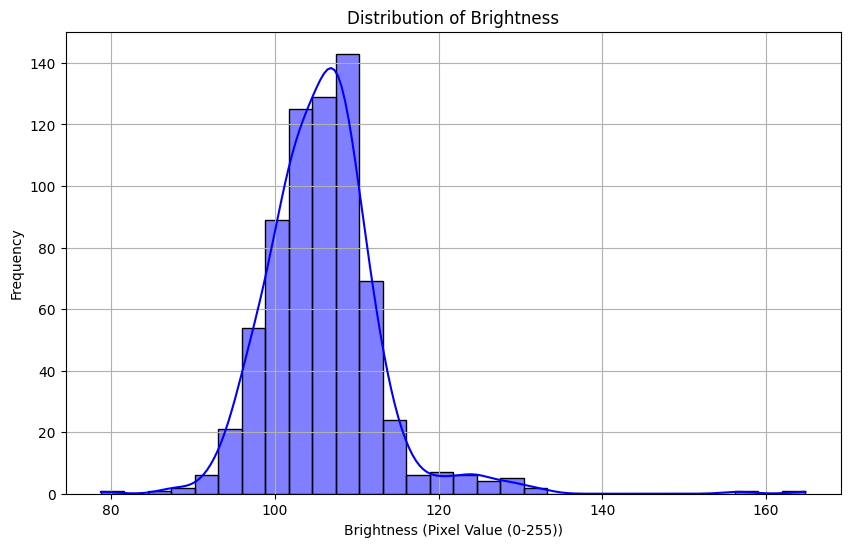

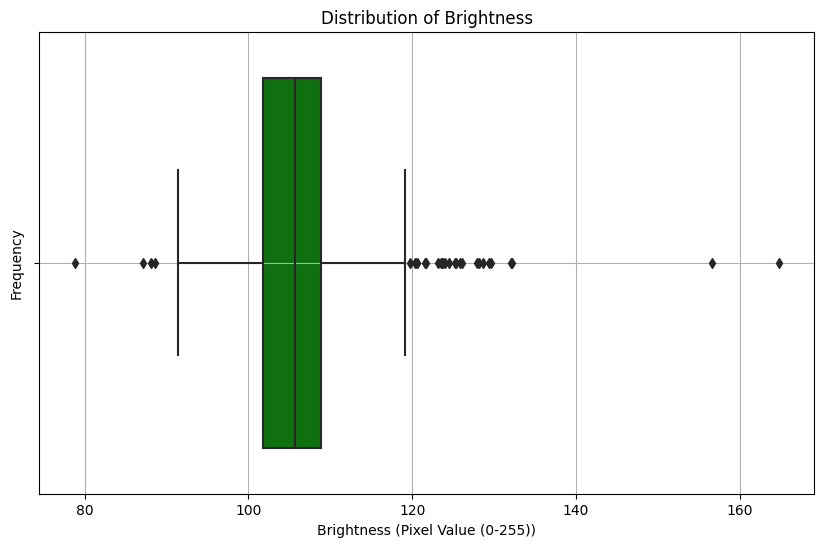

d:\Software\Python\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


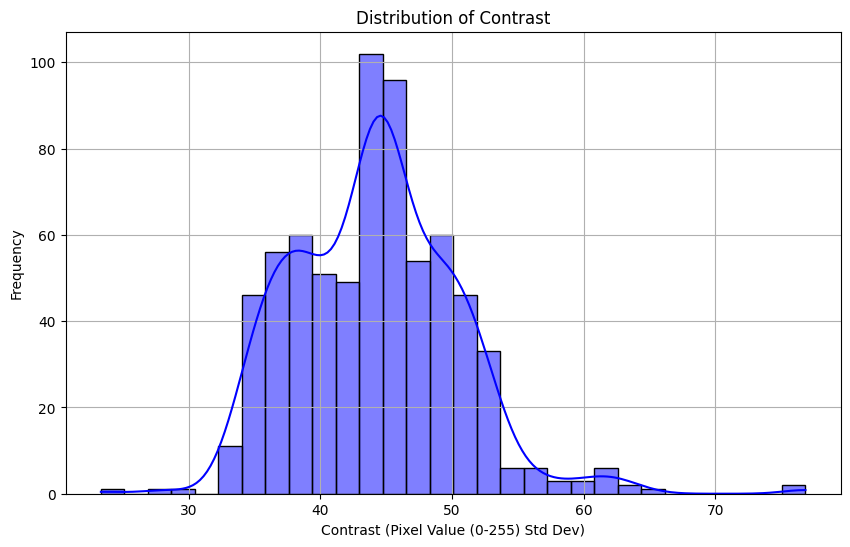

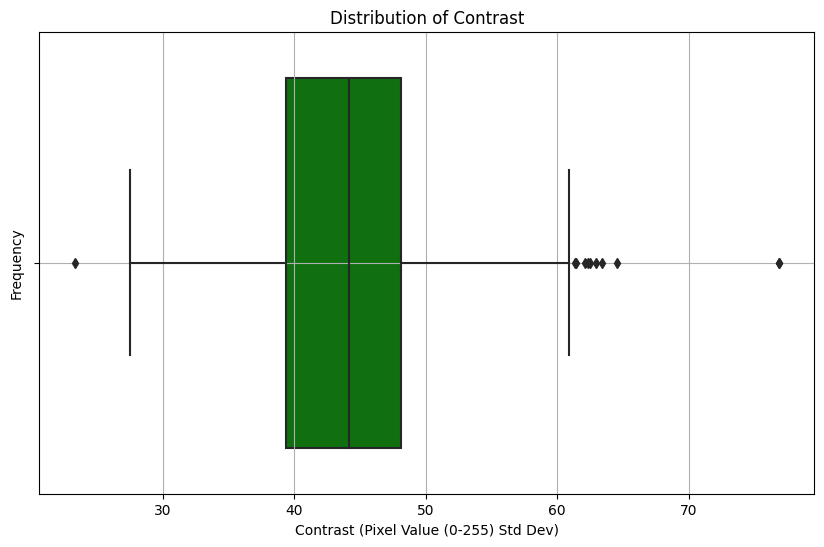

d:\Software\Python\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


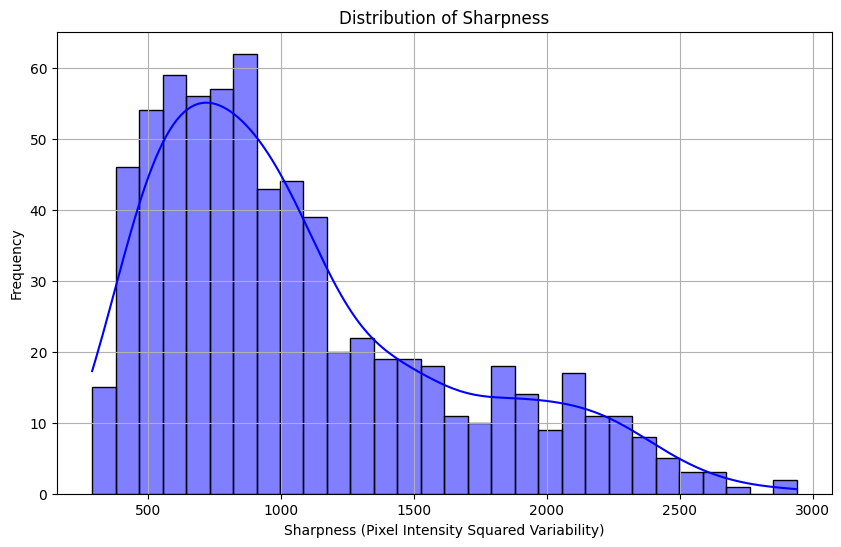

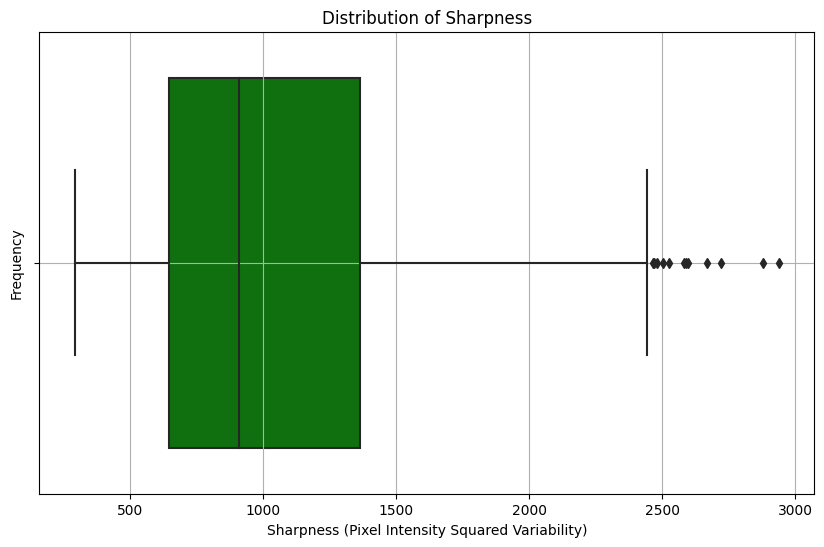

d:\Software\Python\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


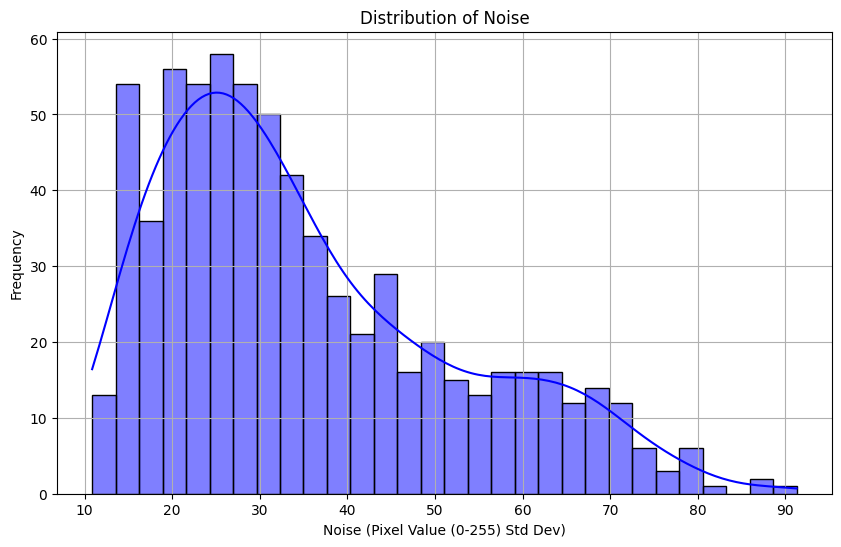

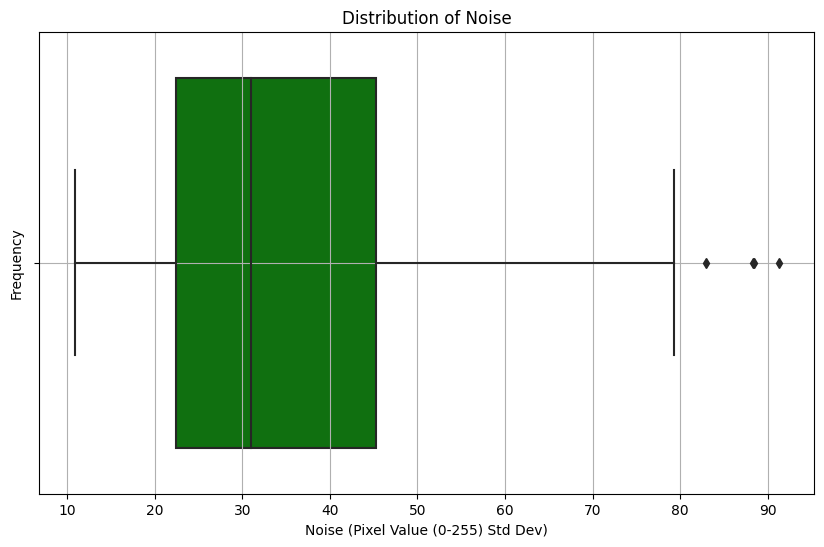

d:\Software\Python\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


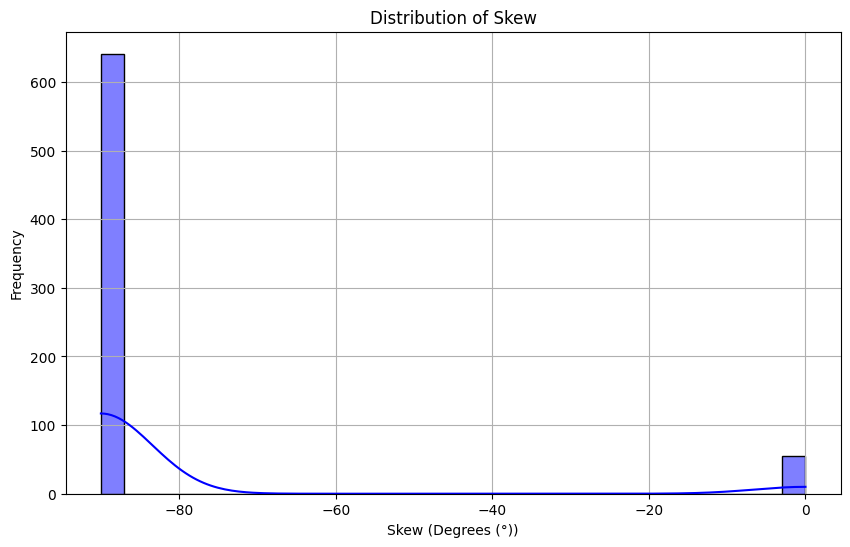

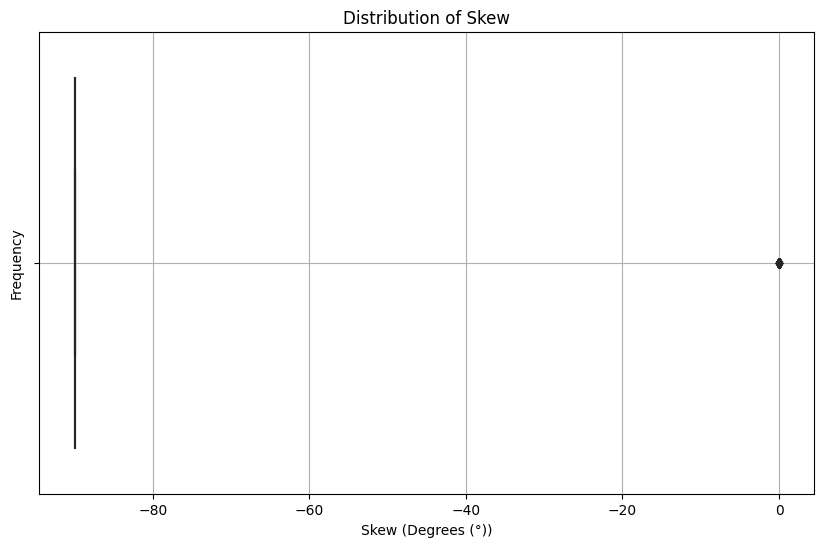

d:\Software\Python\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


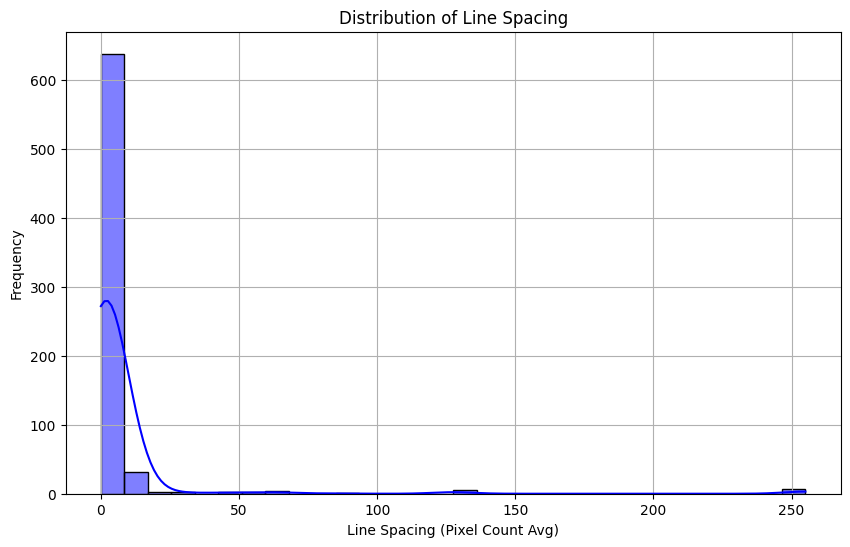

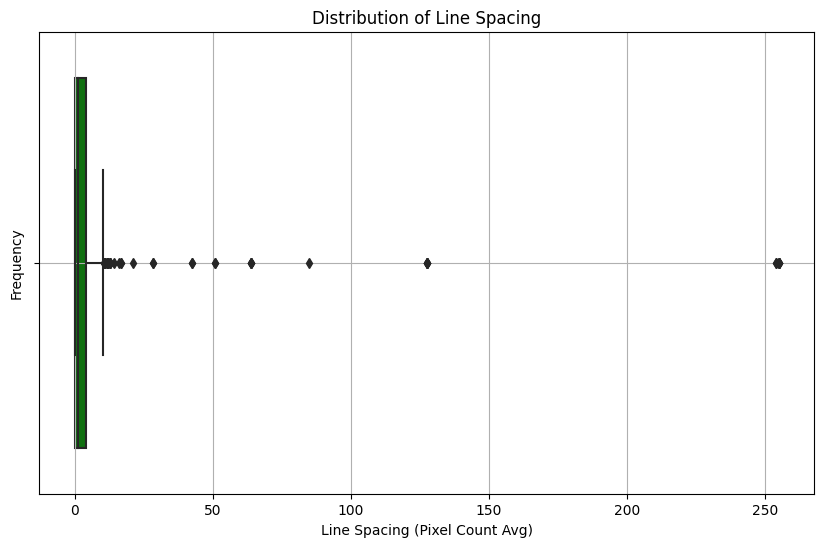

d:\Software\Python\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


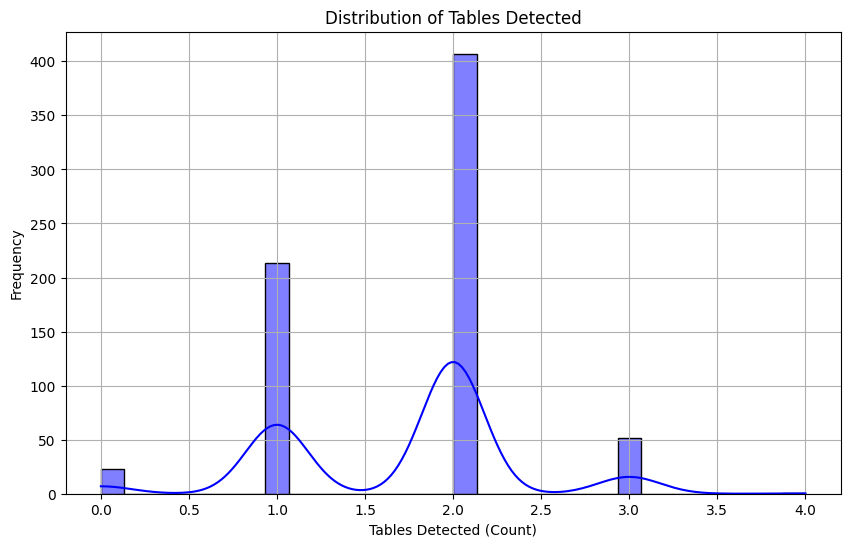

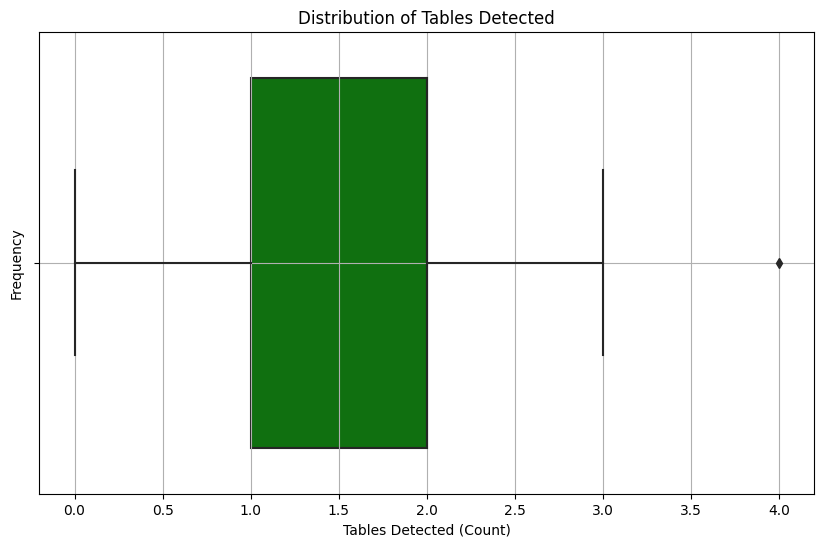

d:\Software\Python\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


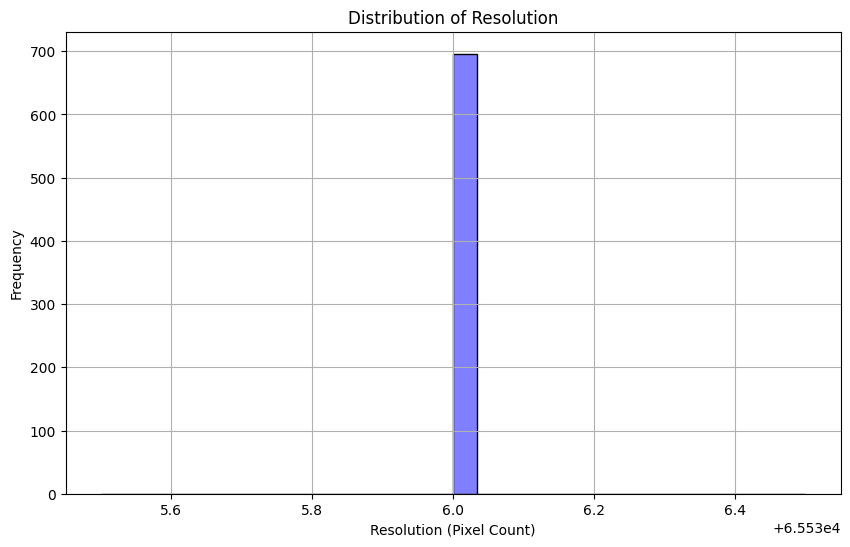

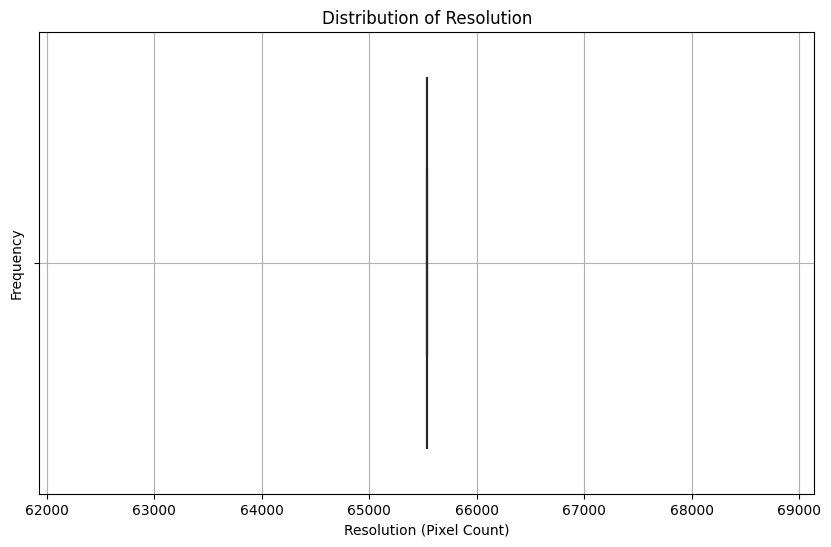

d:\Software\Python\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


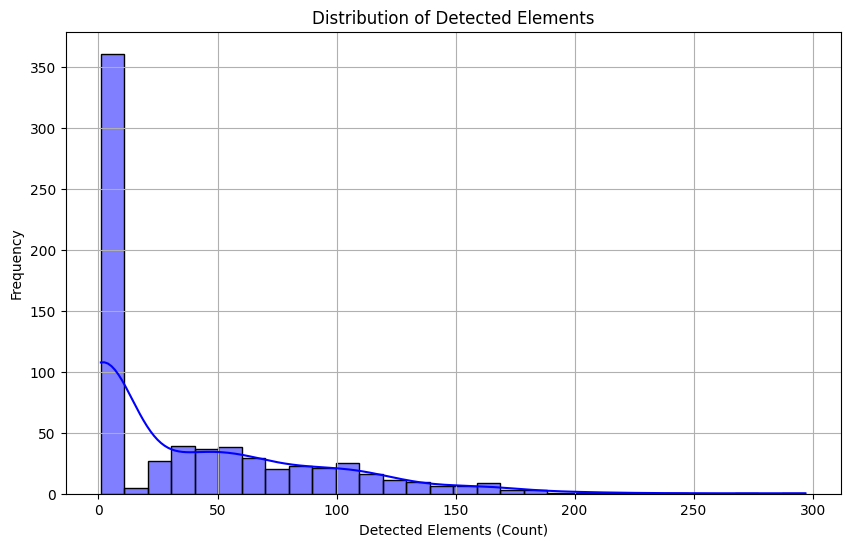

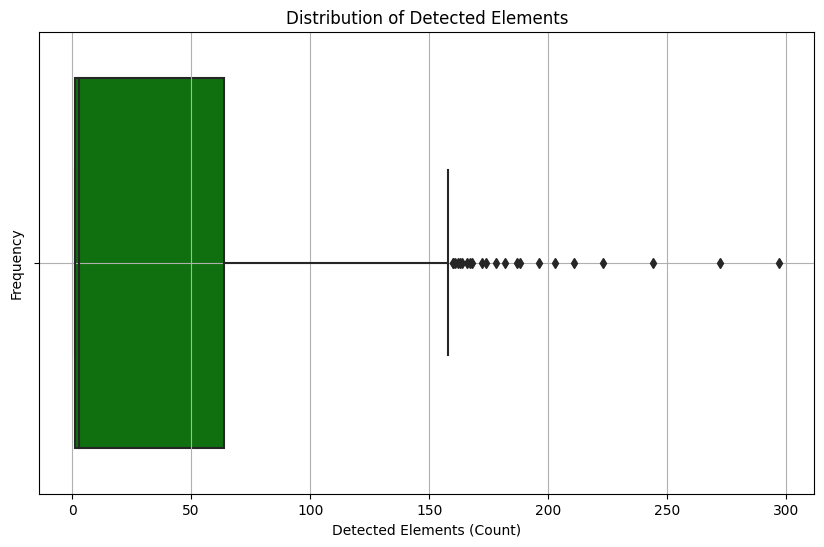

d:\Software\Python\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


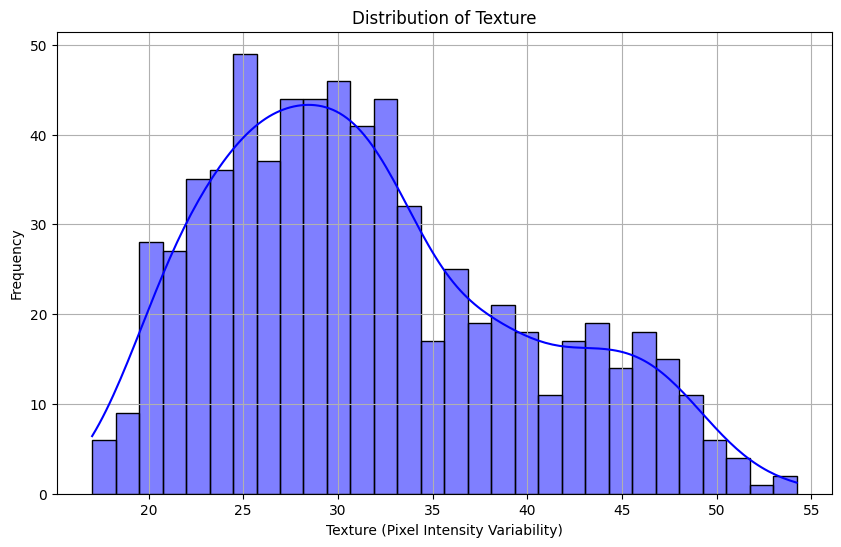

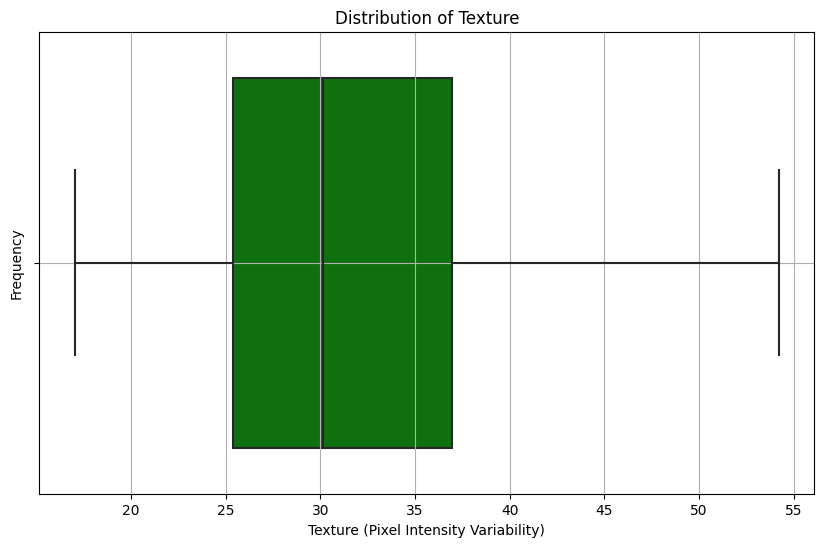

d:\Software\Python\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


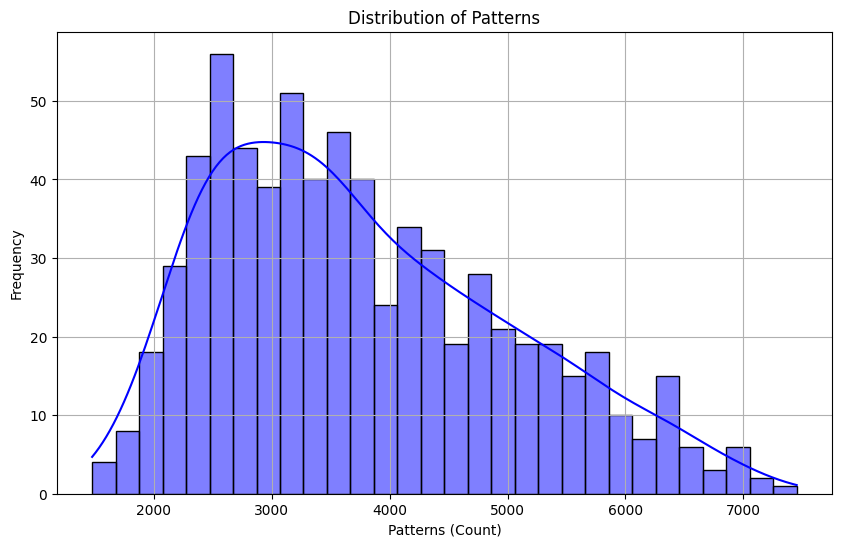

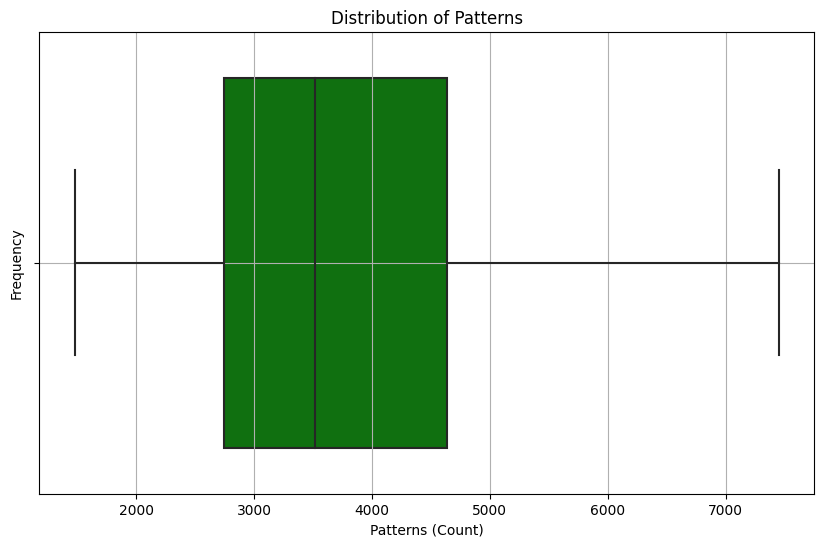

In [28]:
# Loop through each characteristic and its corresponding unit
for characteristic, unit in characteristics_units.items():
    for plot_type in ['hist', 'box']:
        plot_characteristic_distribution(df_stats, characteristic, unit, plot_type)

### Step 5: Visualize relationships between characteristics

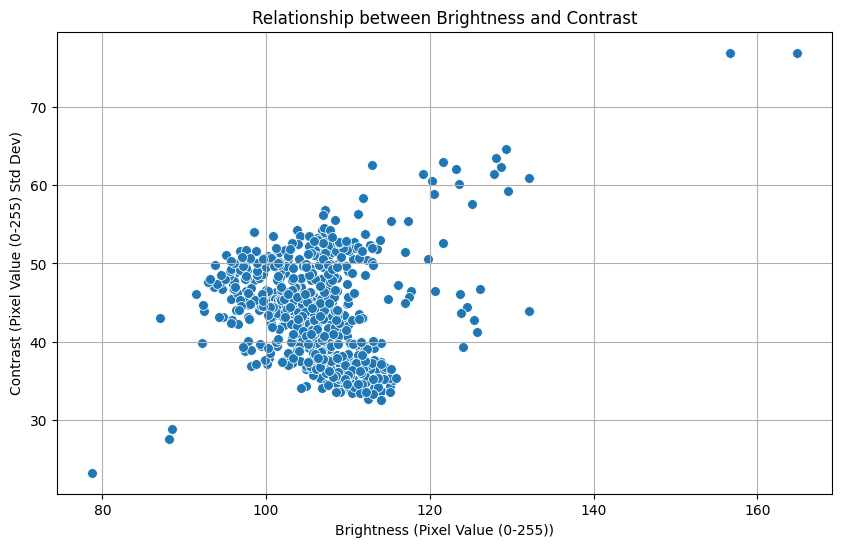

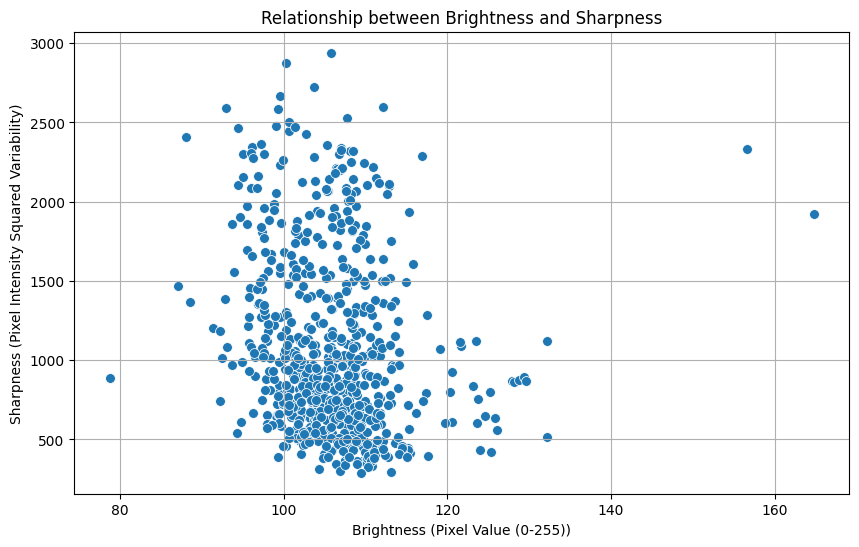

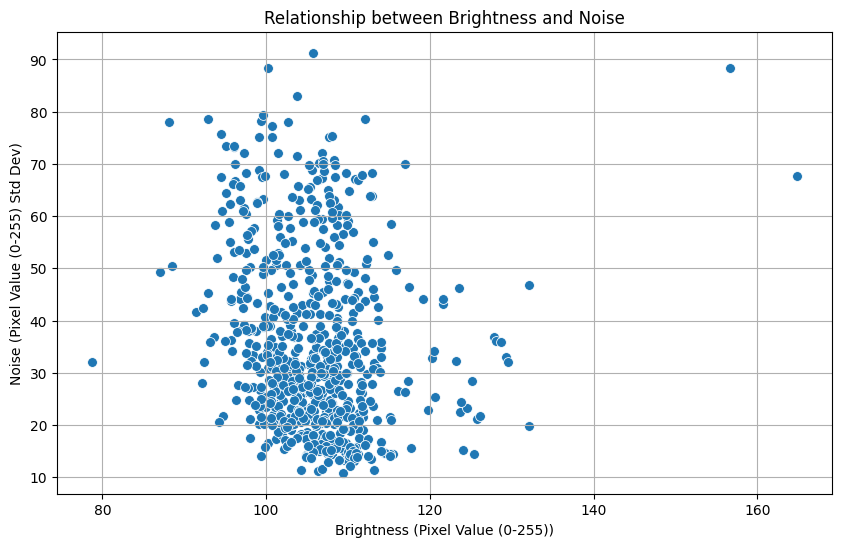

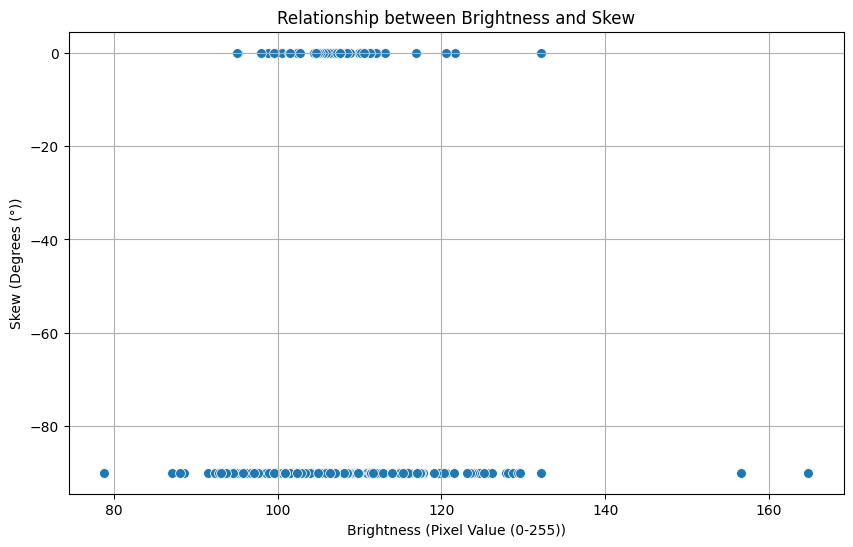

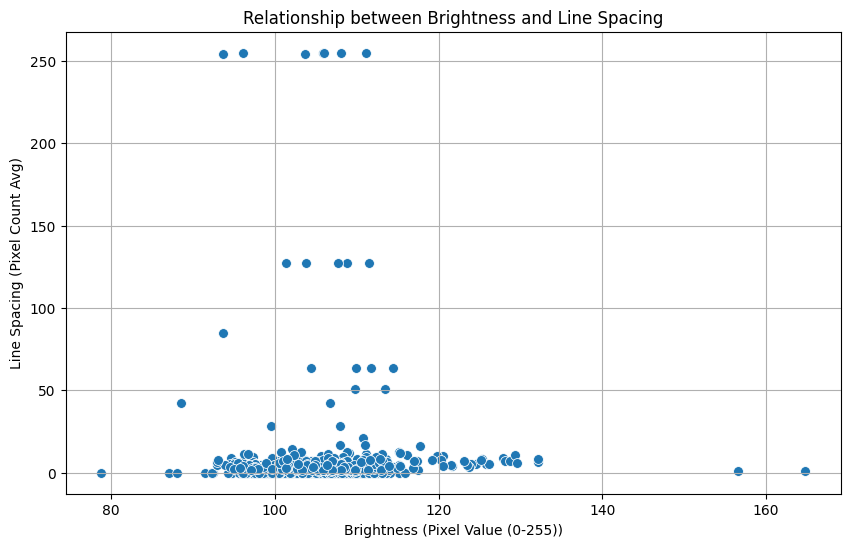

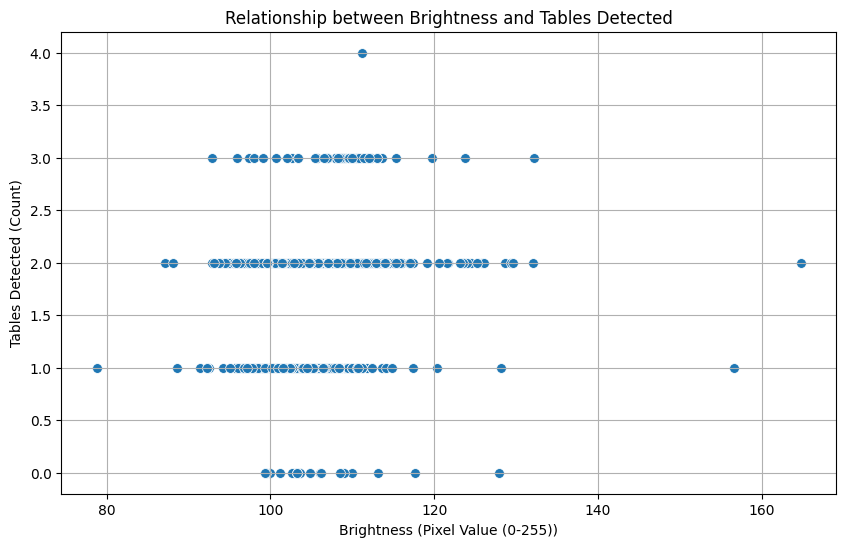

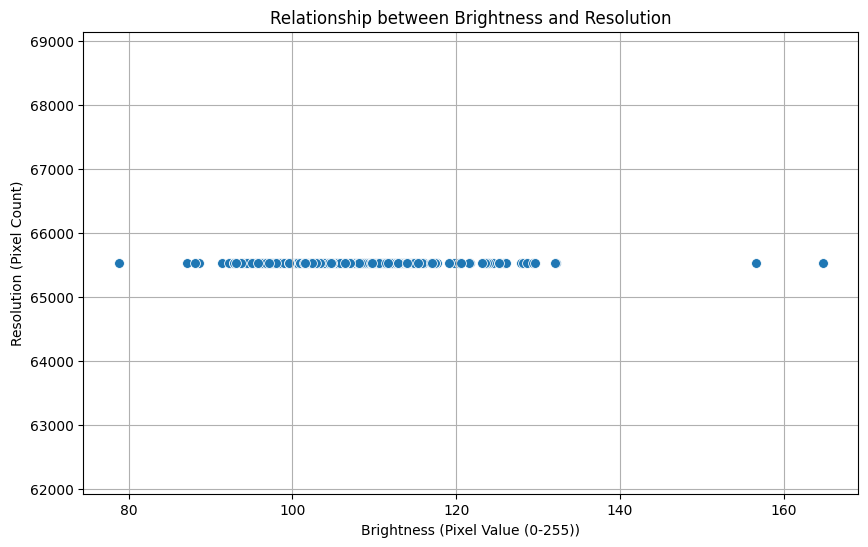

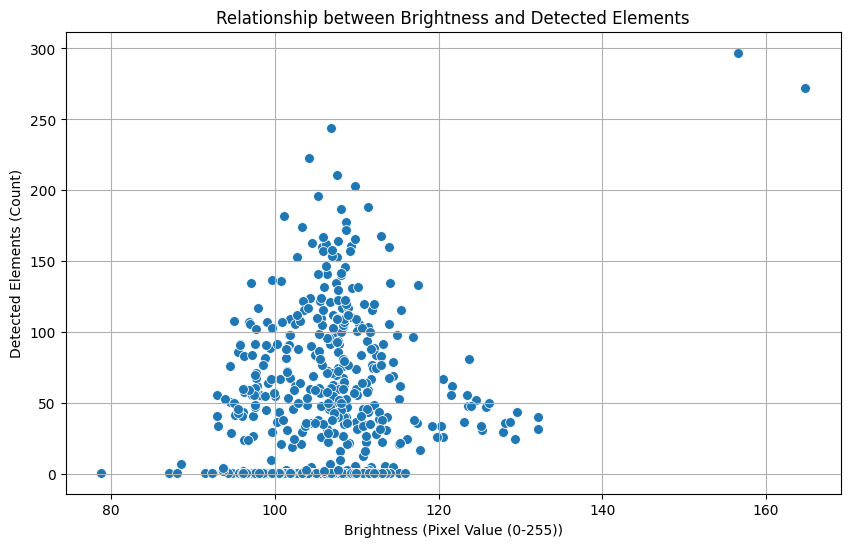

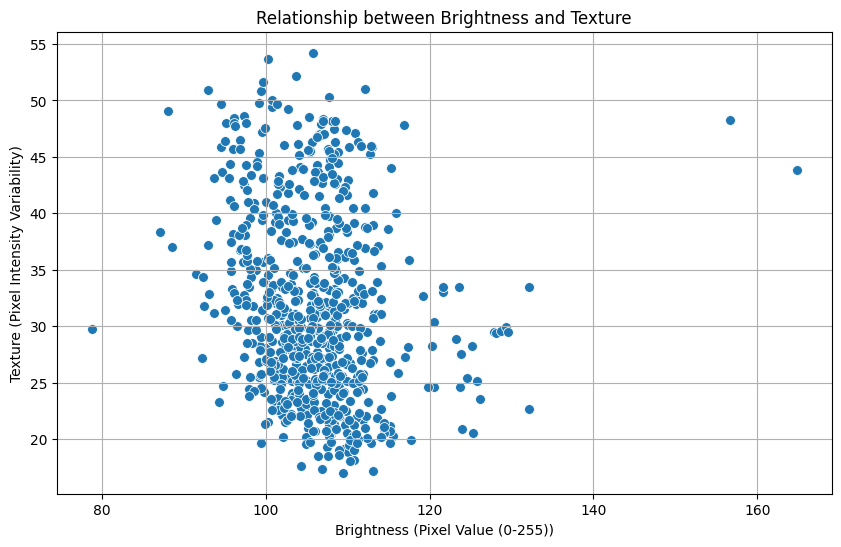

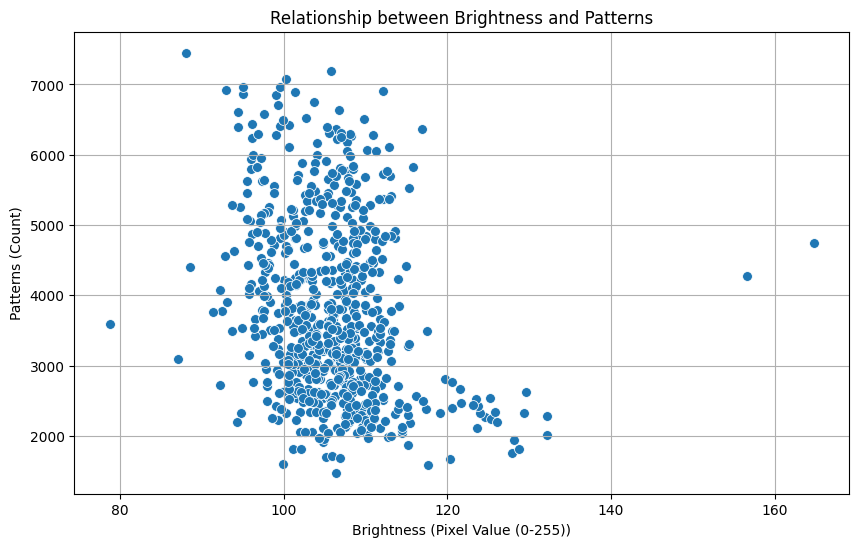

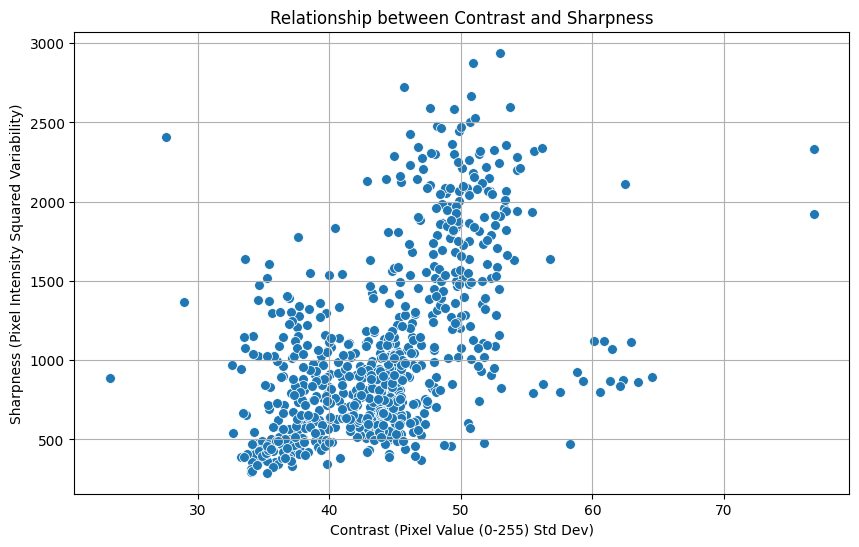

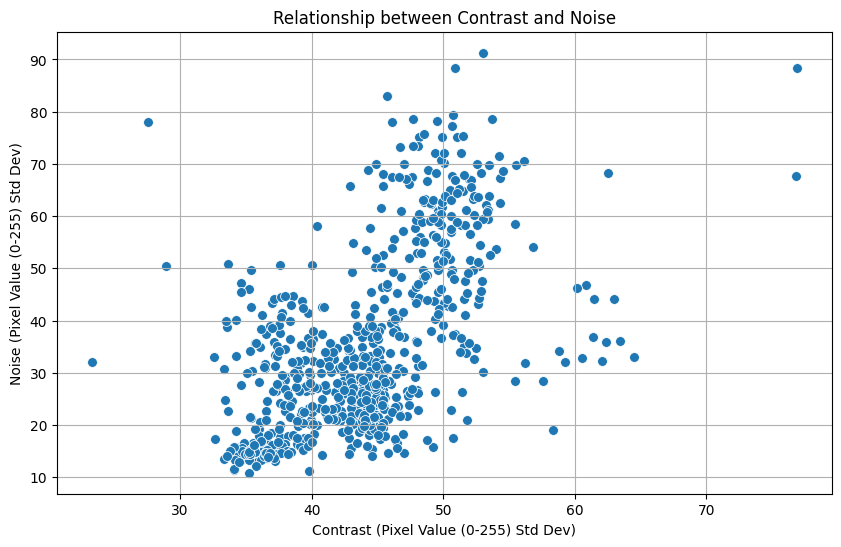

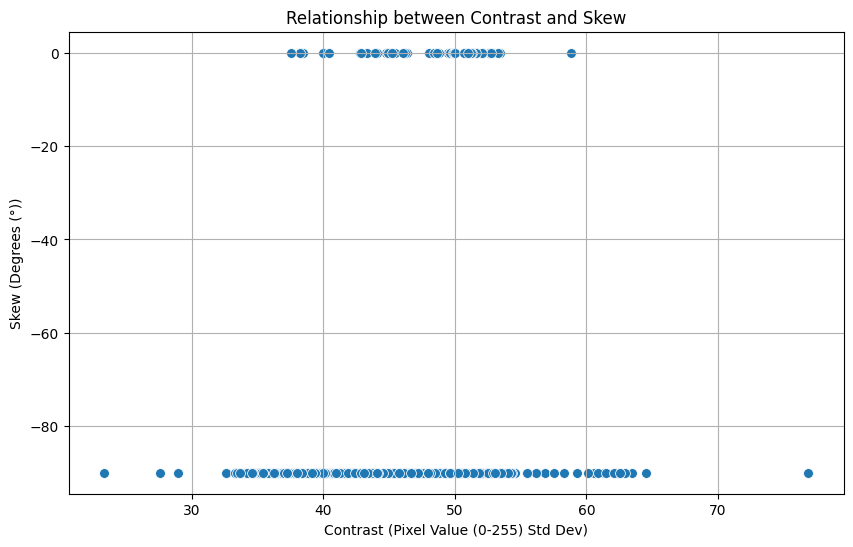

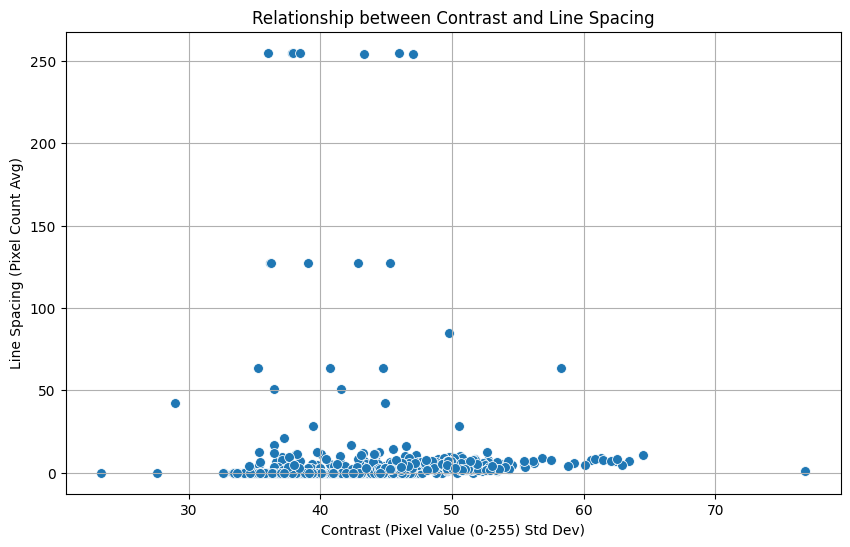

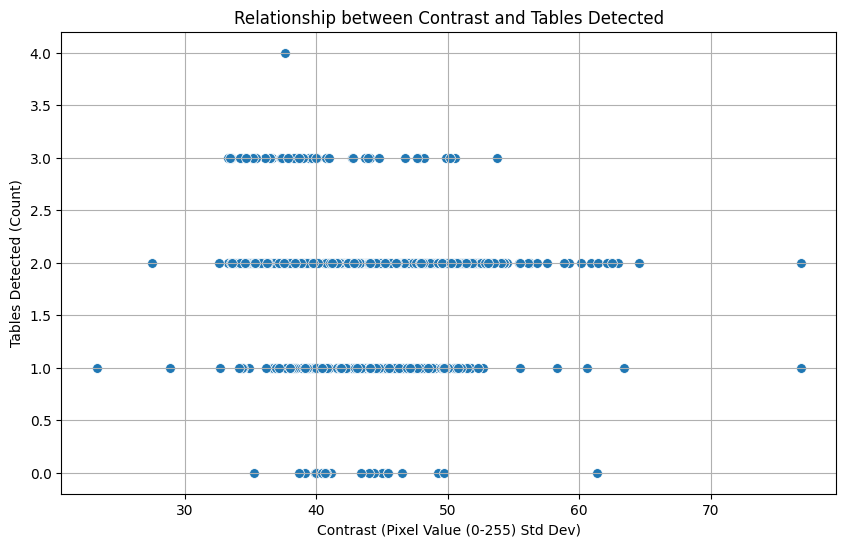

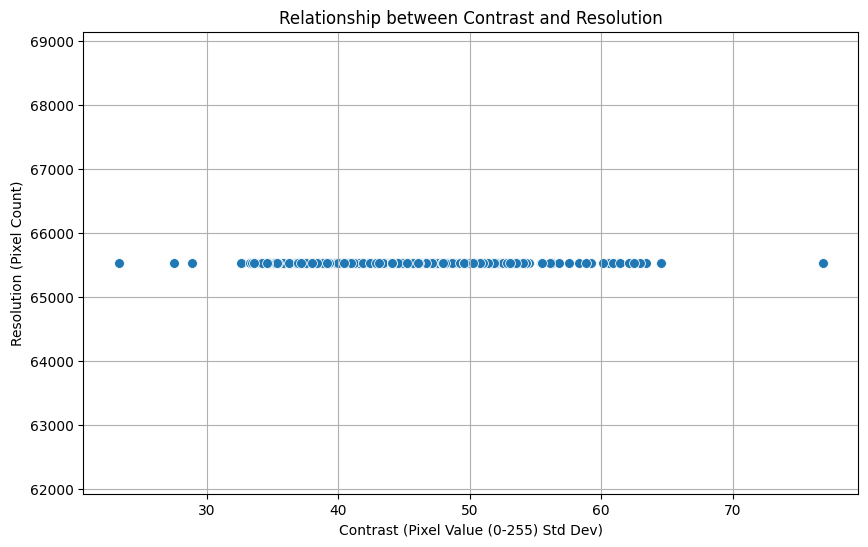

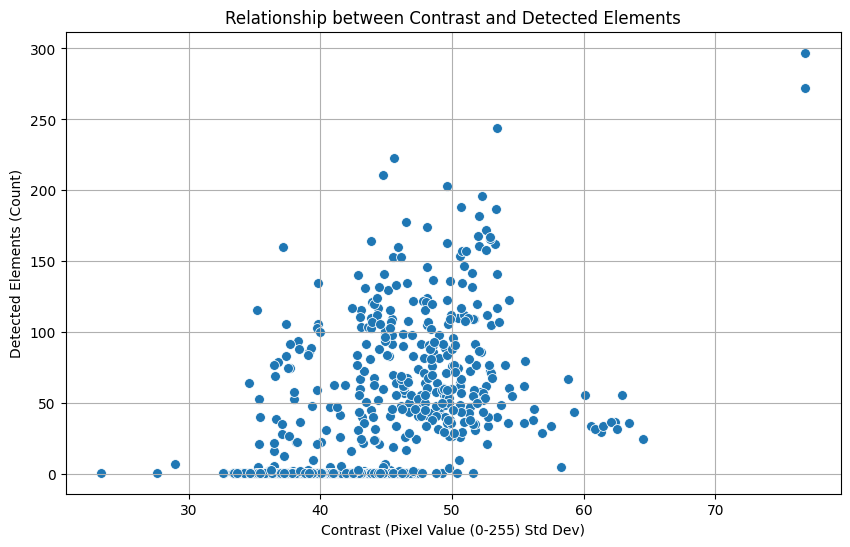

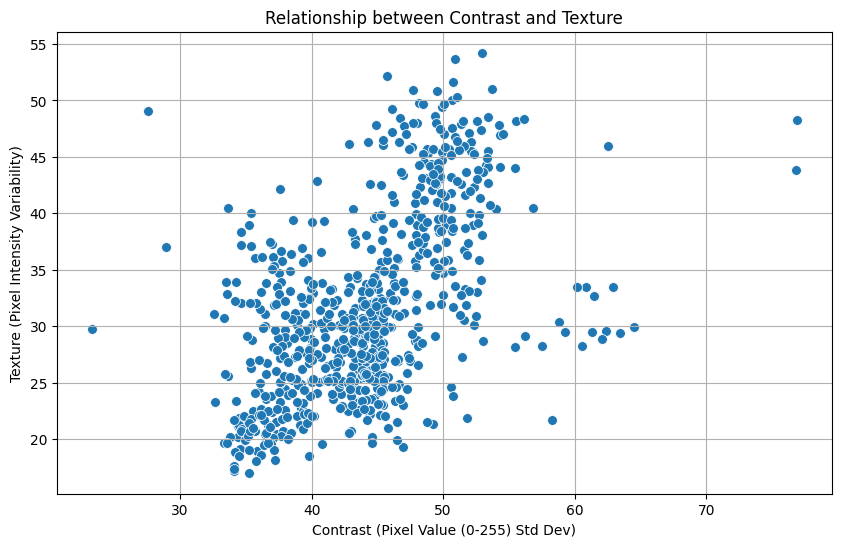

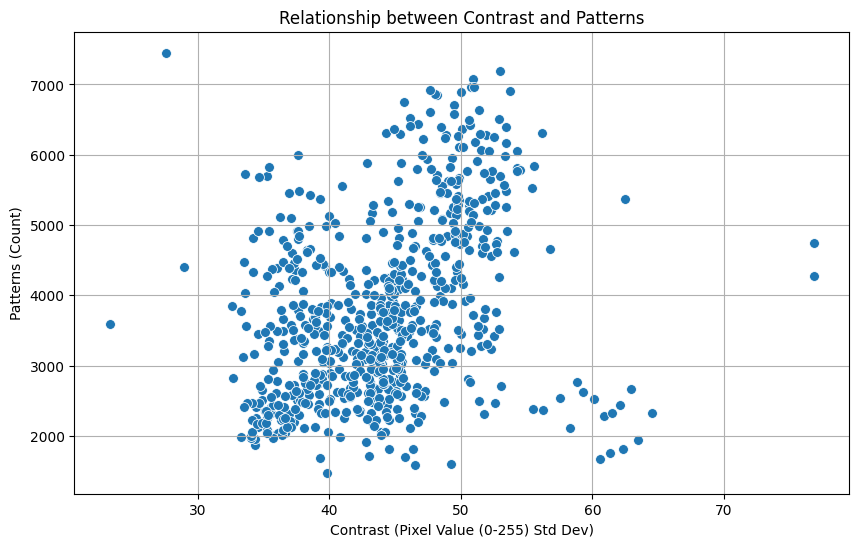

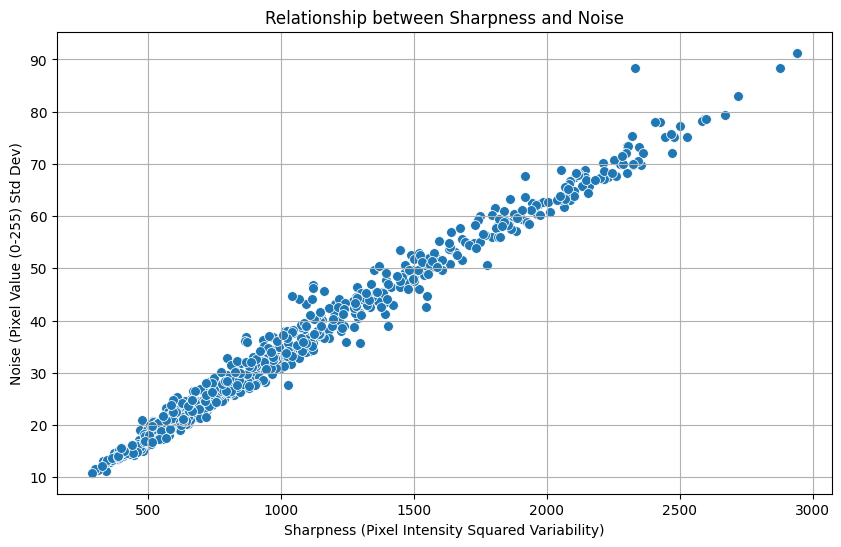

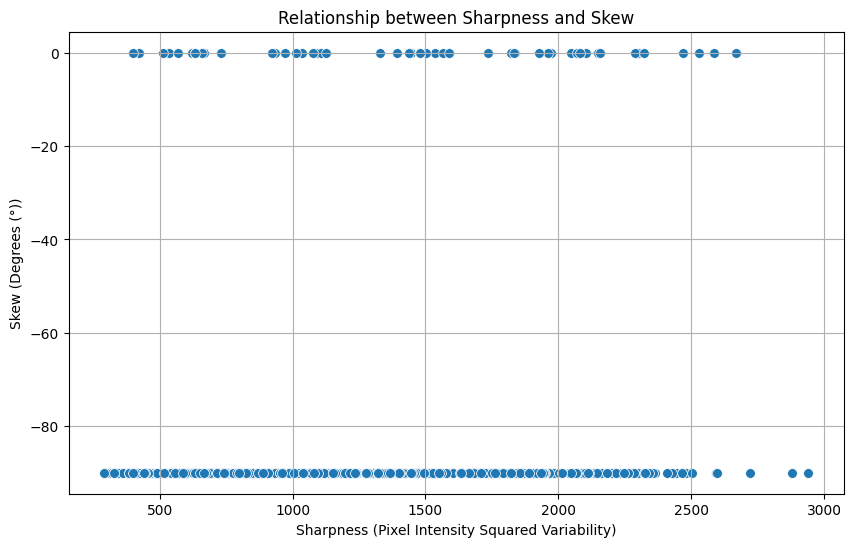

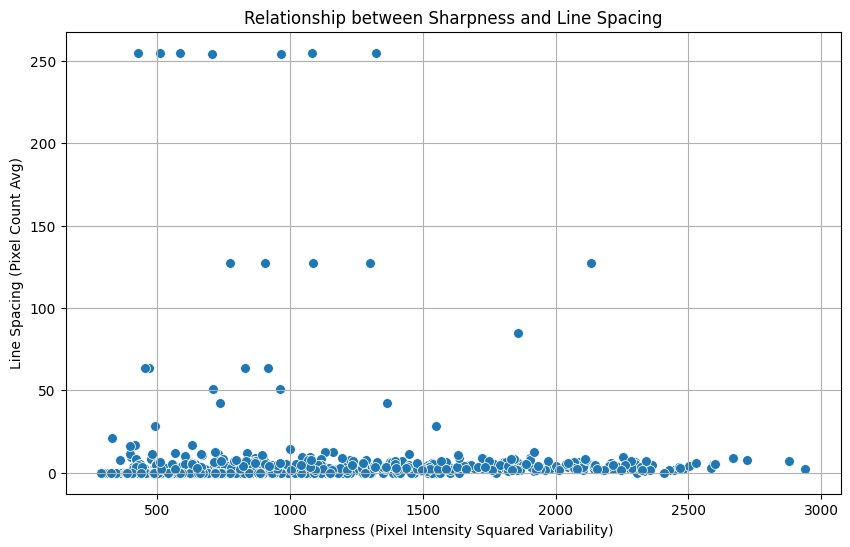

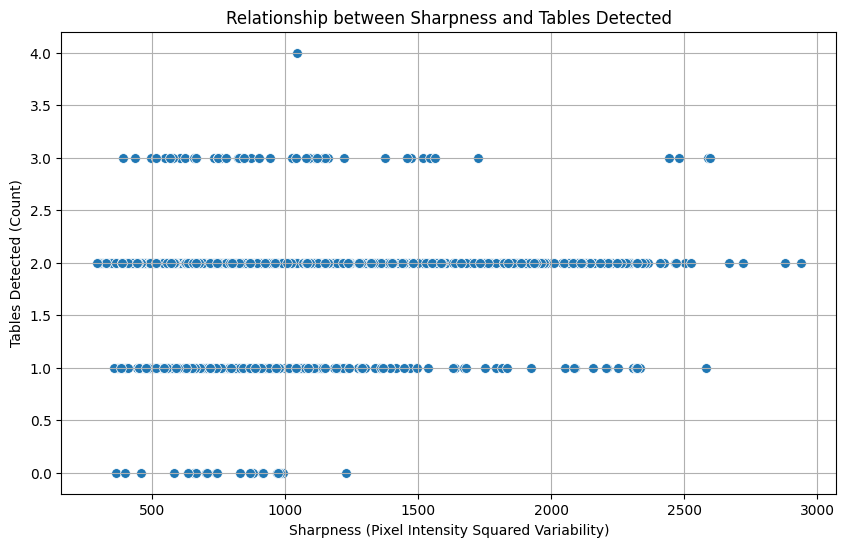

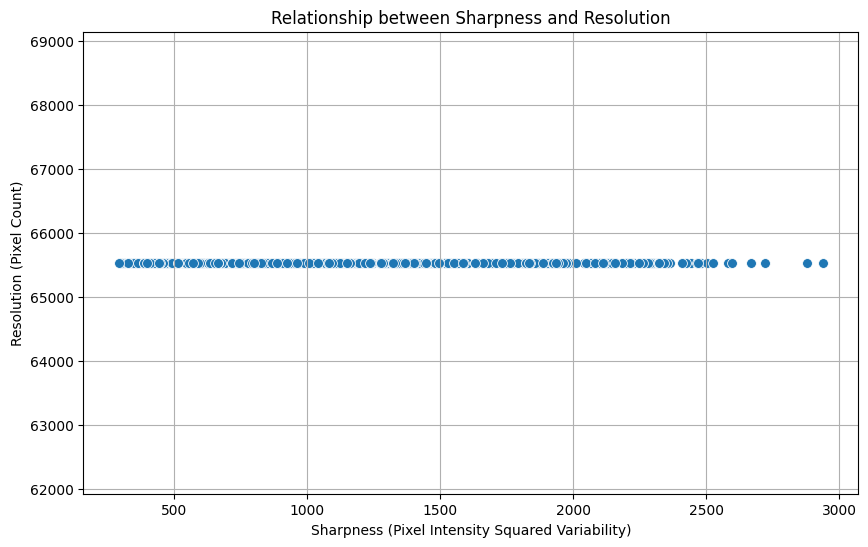

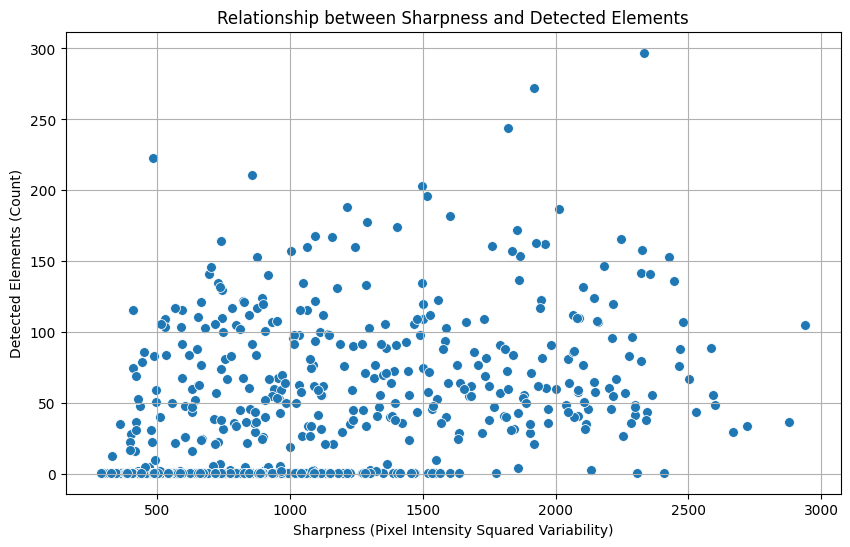

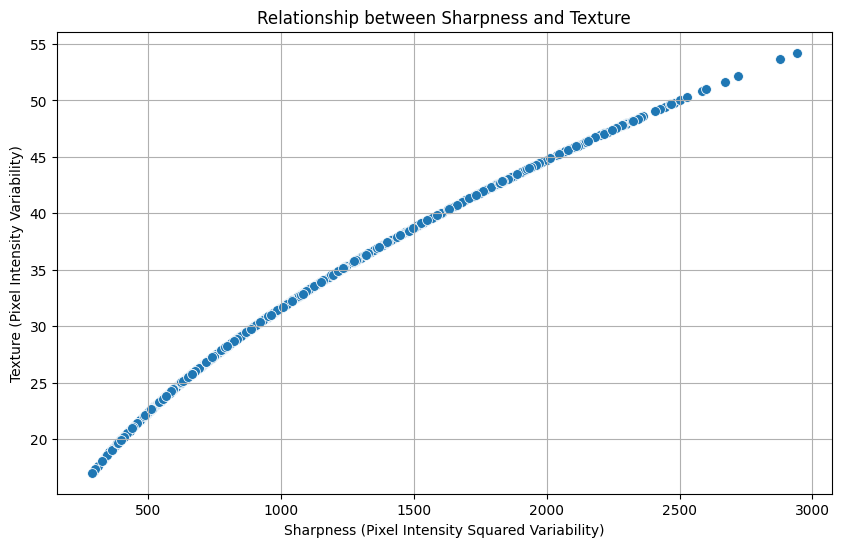

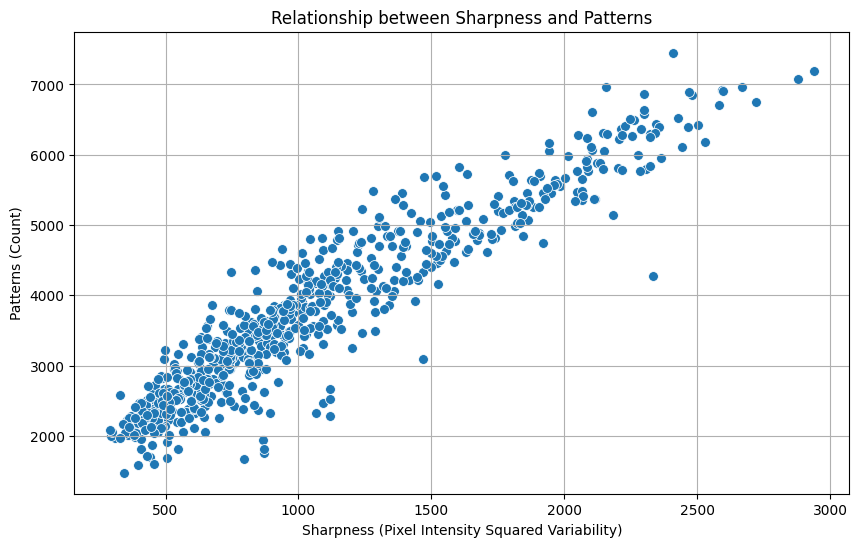

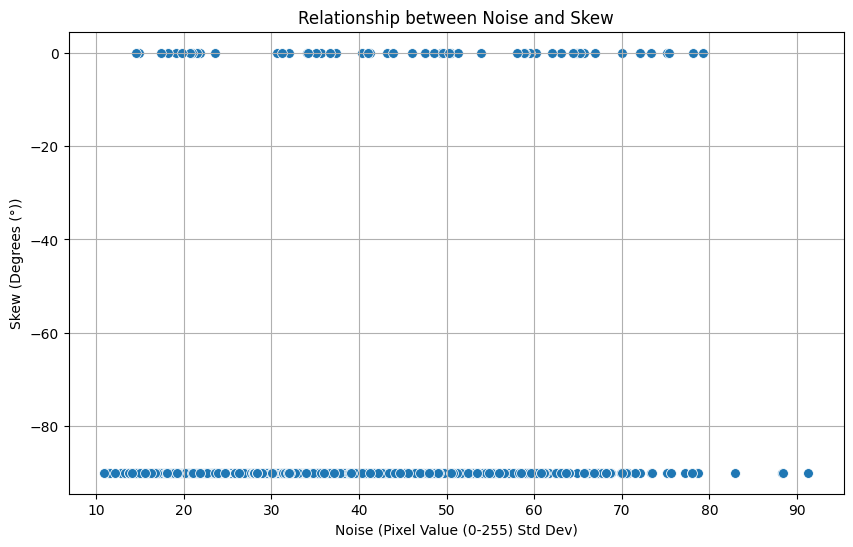

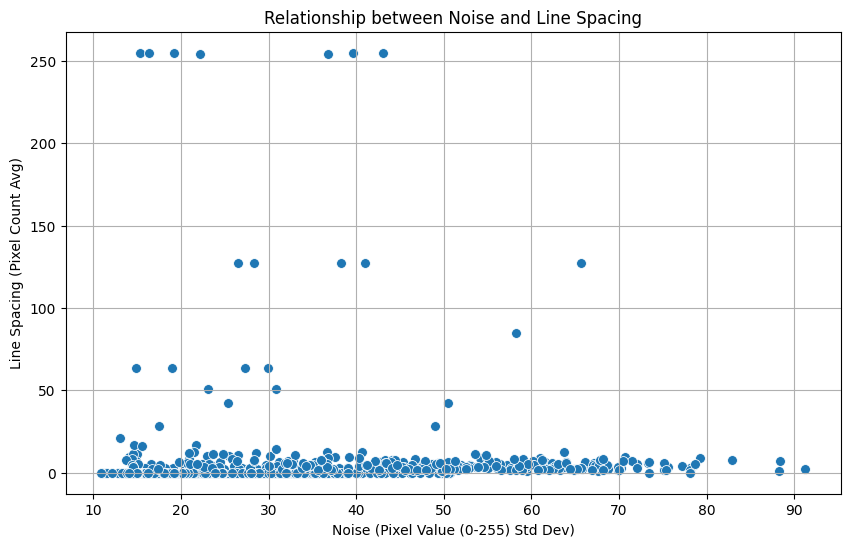

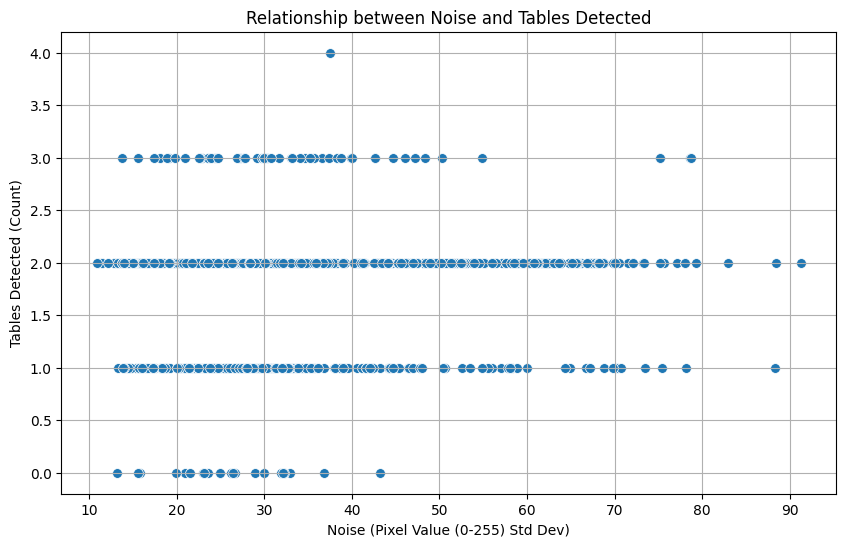

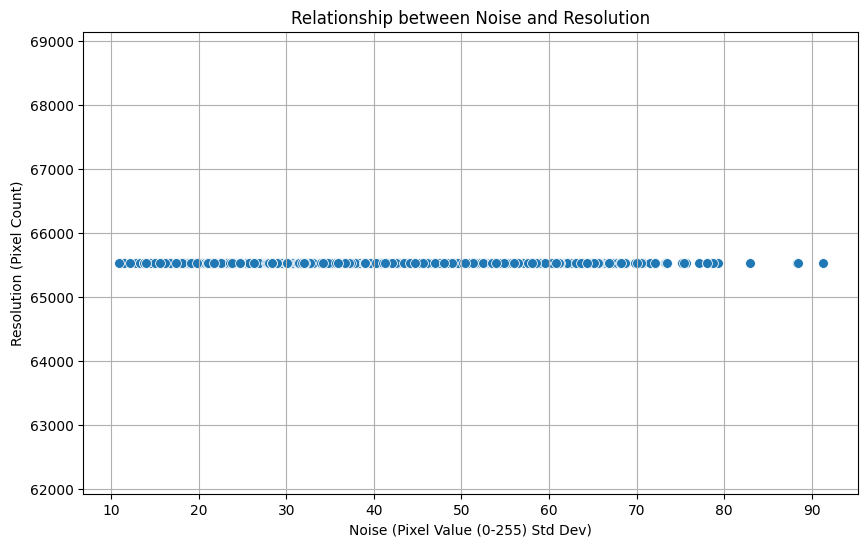

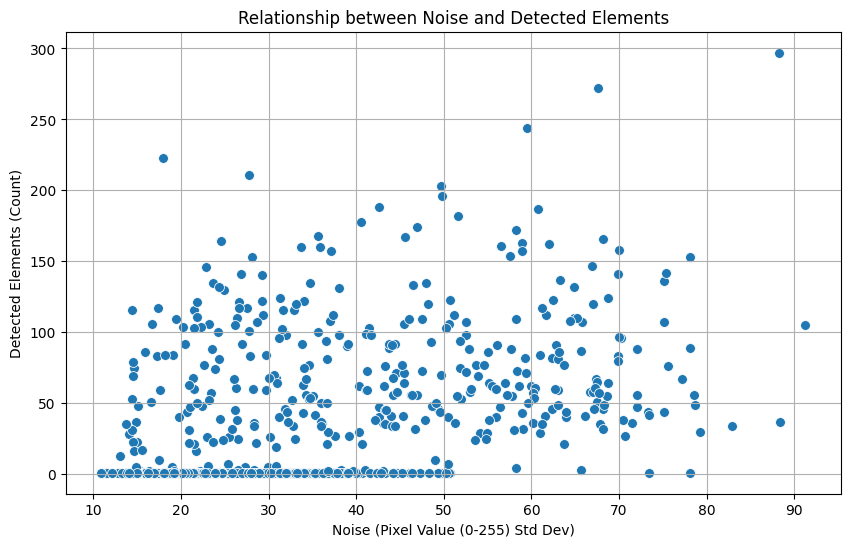

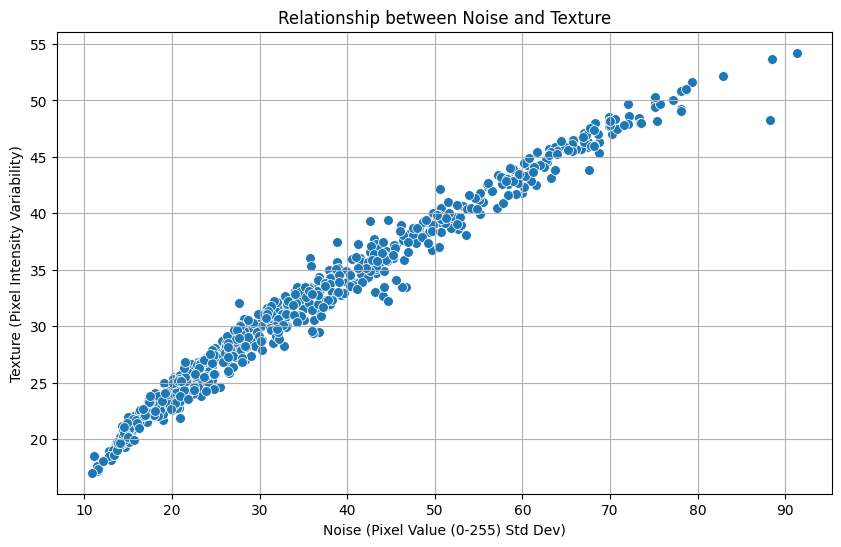

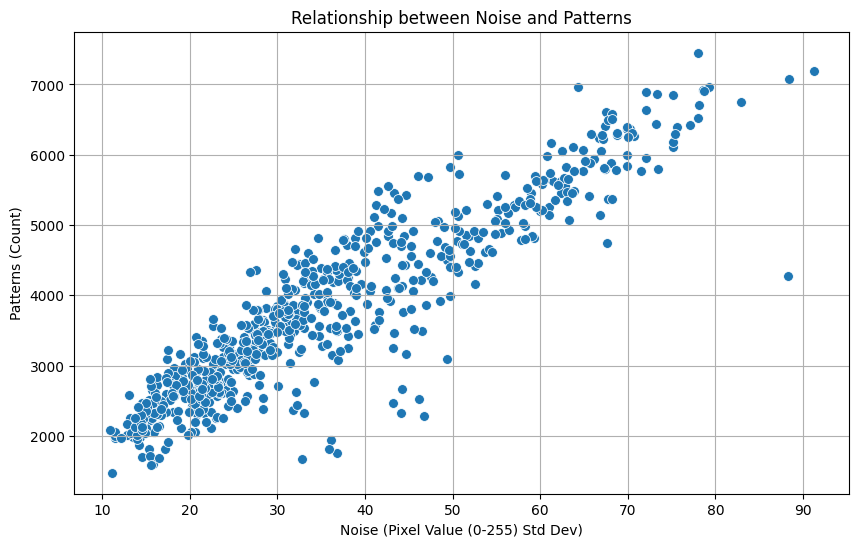

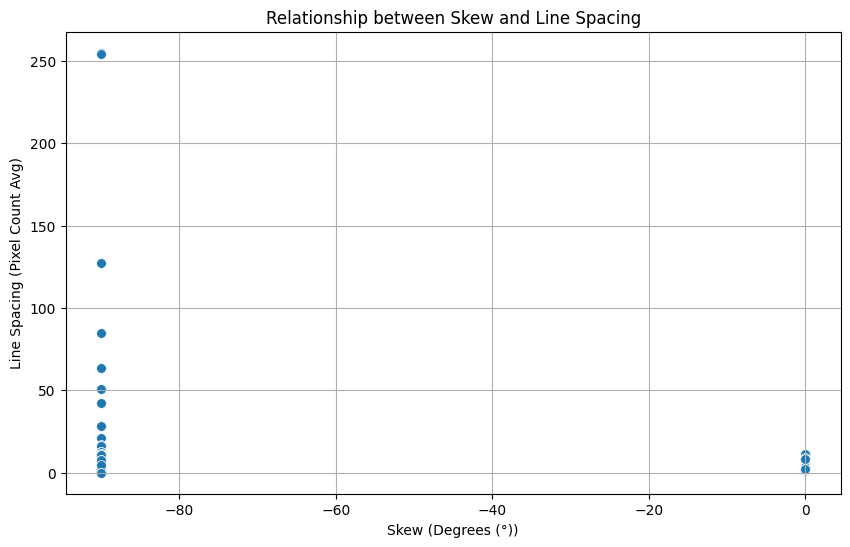

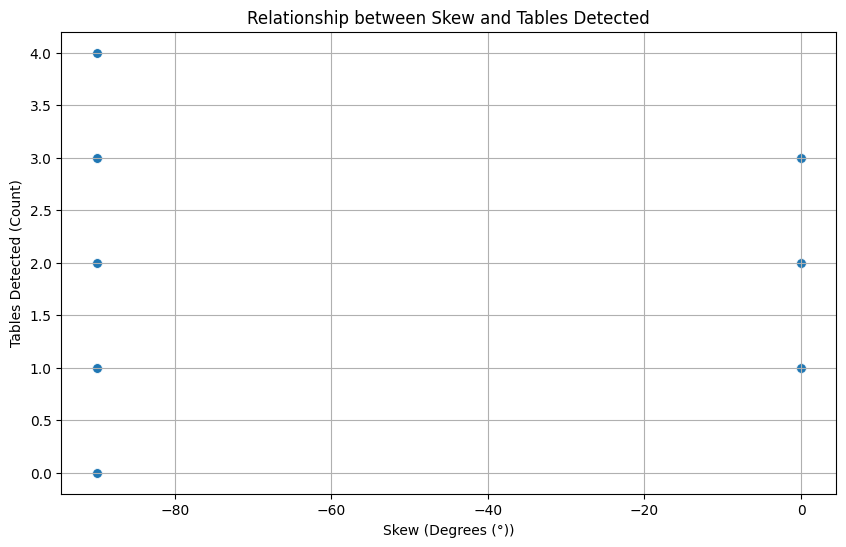

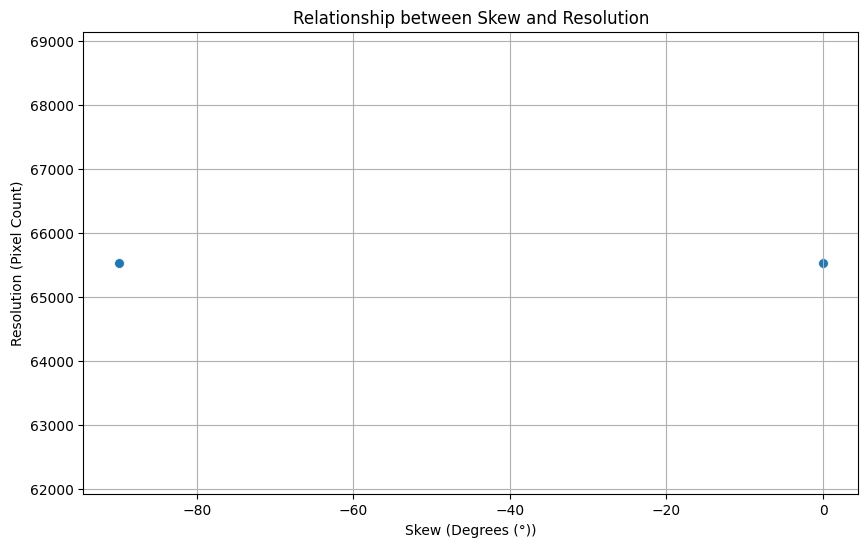

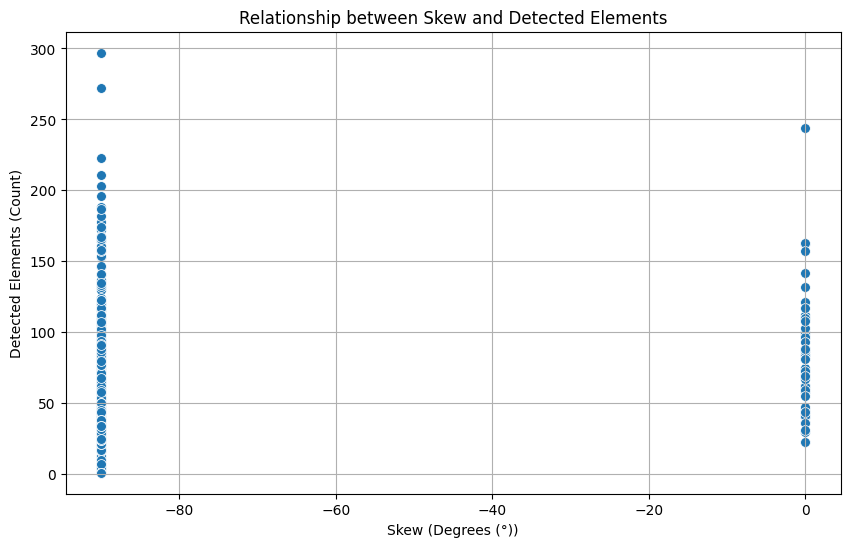

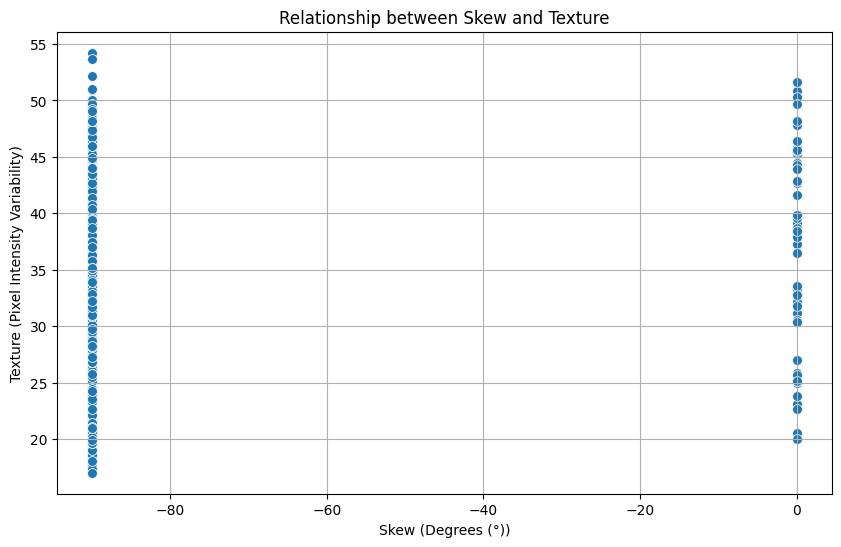

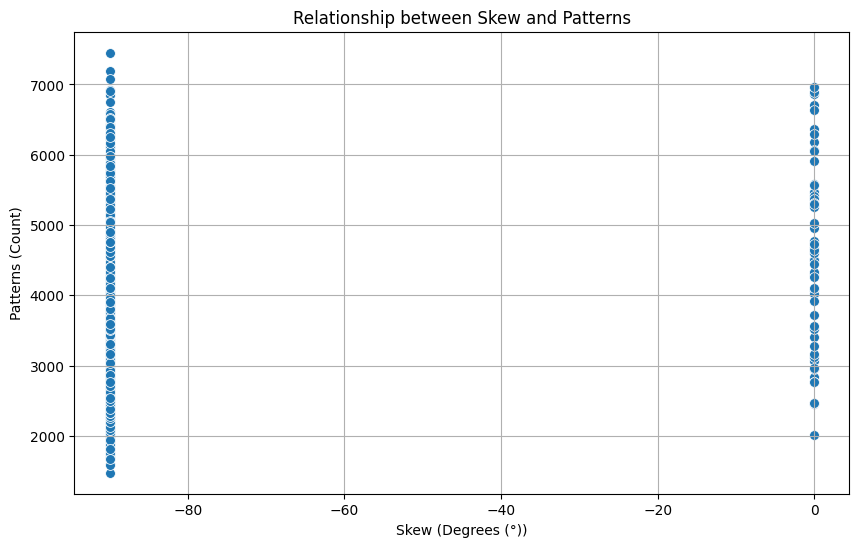

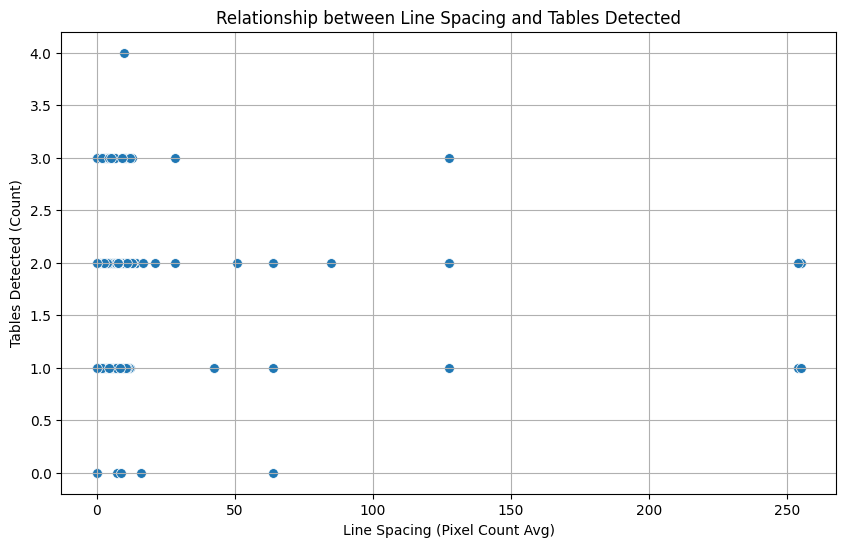

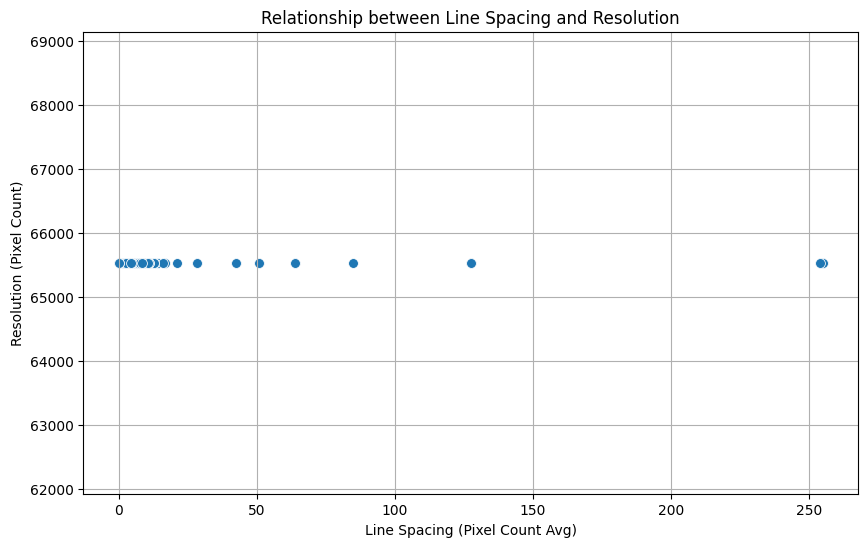

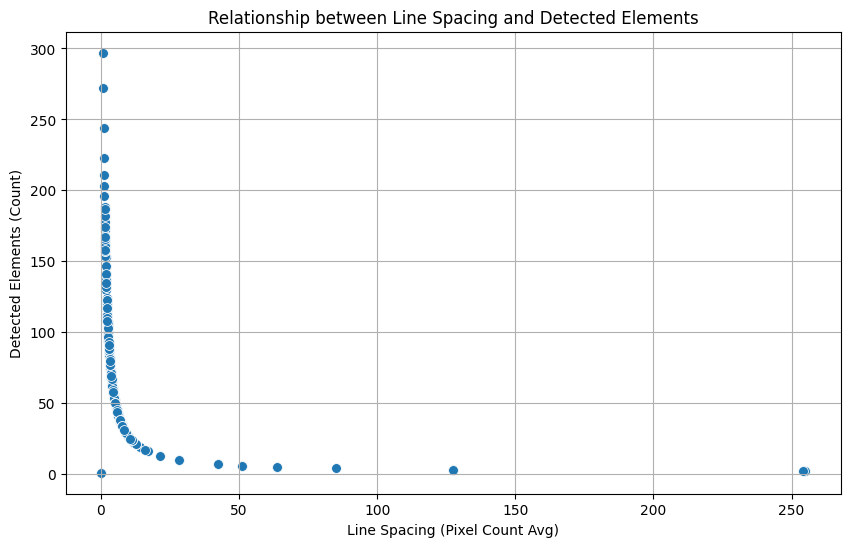

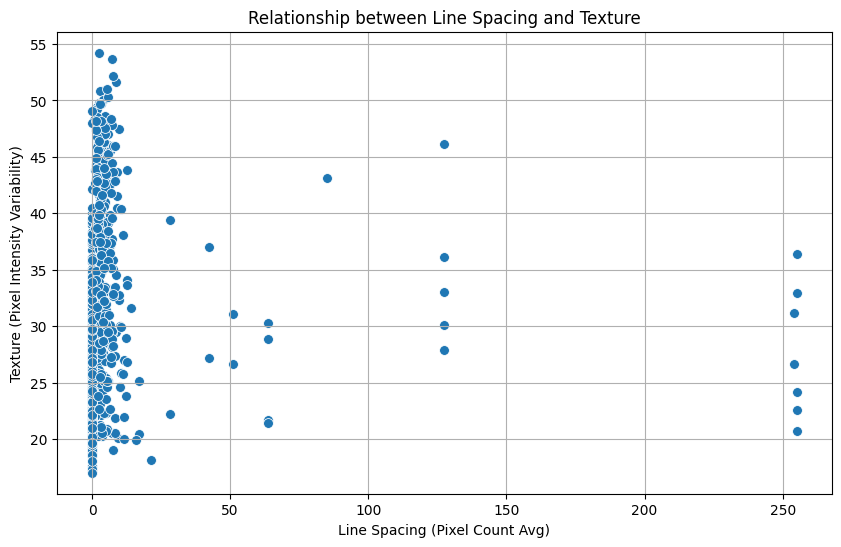

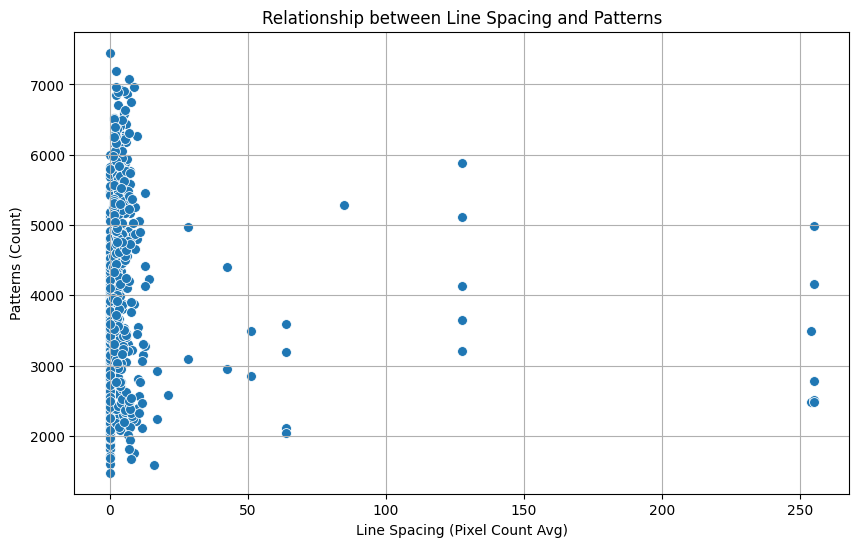

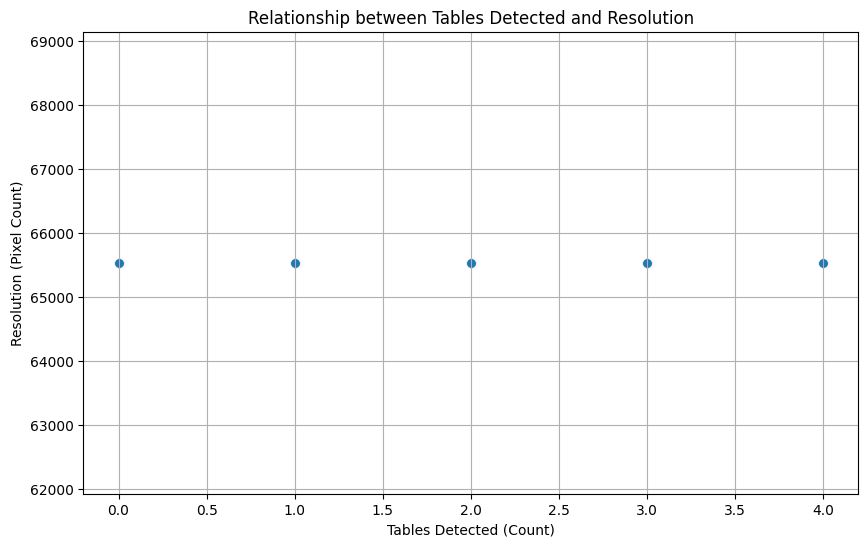

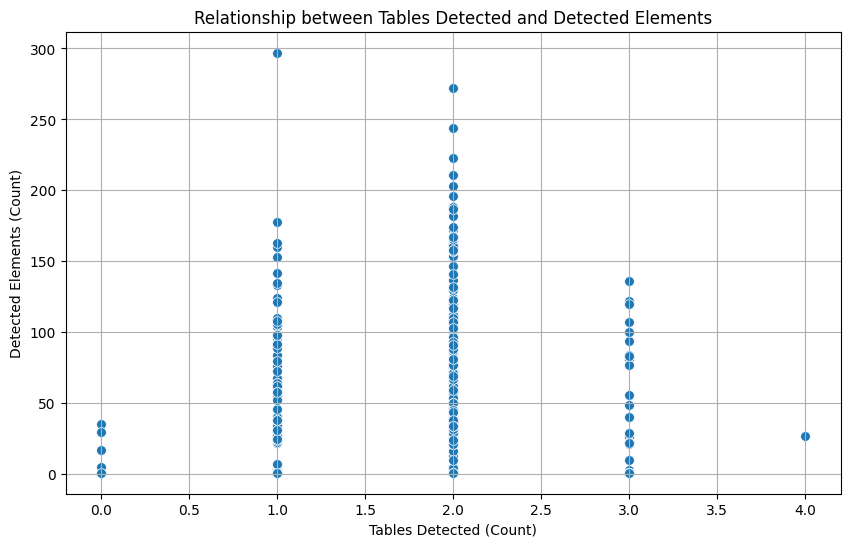

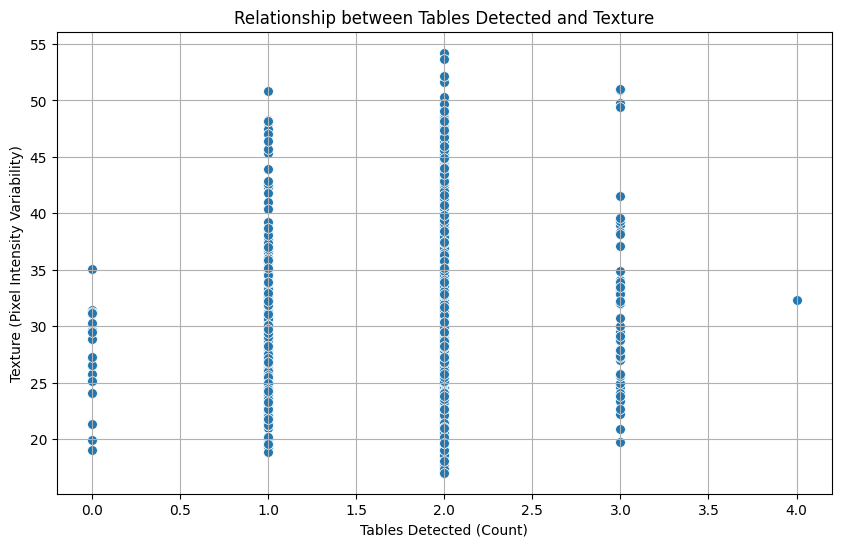

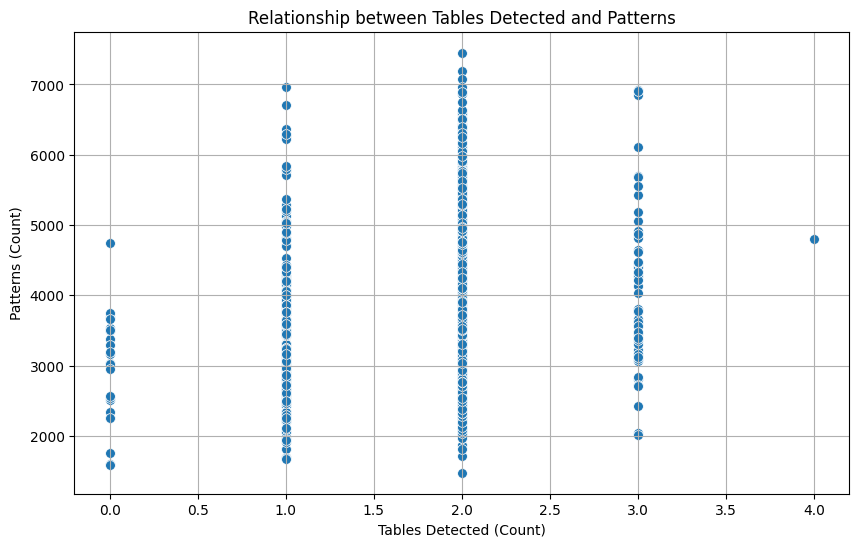

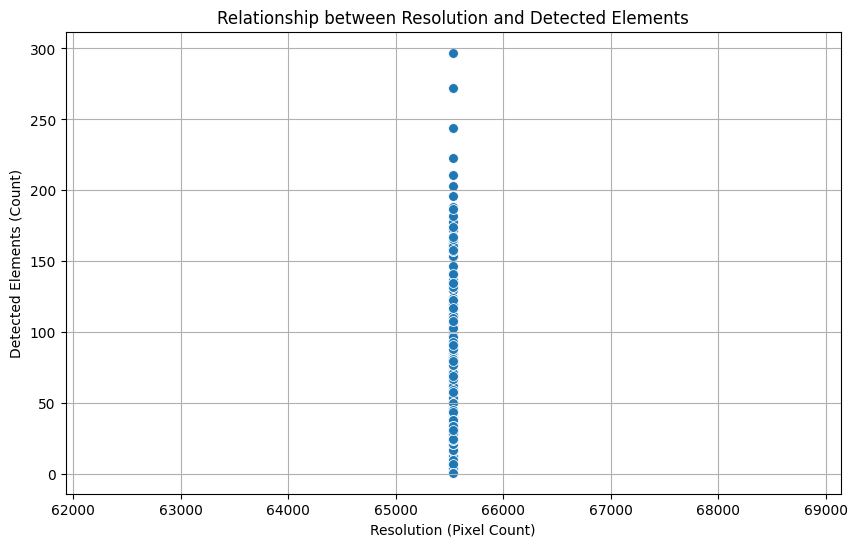

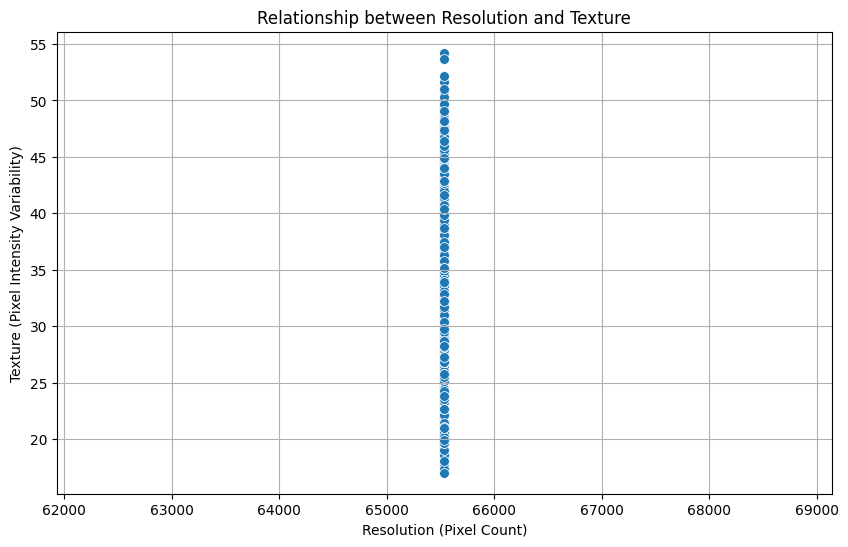

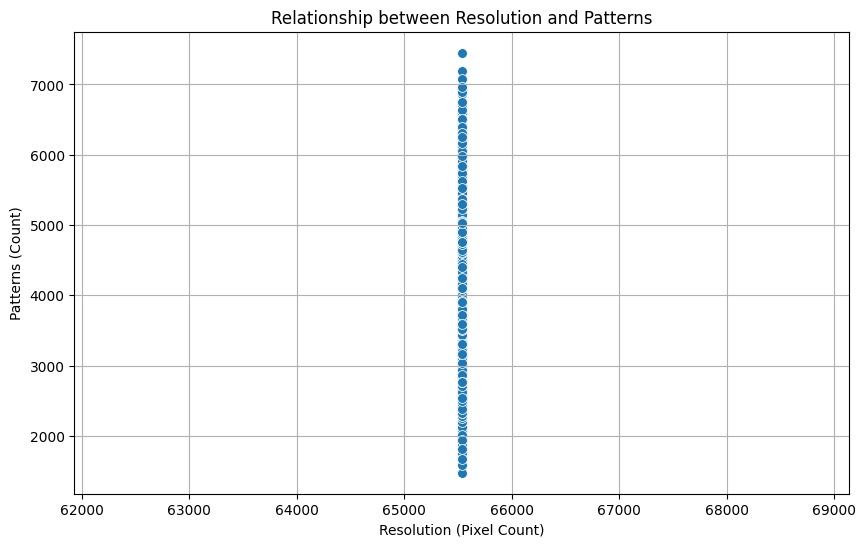

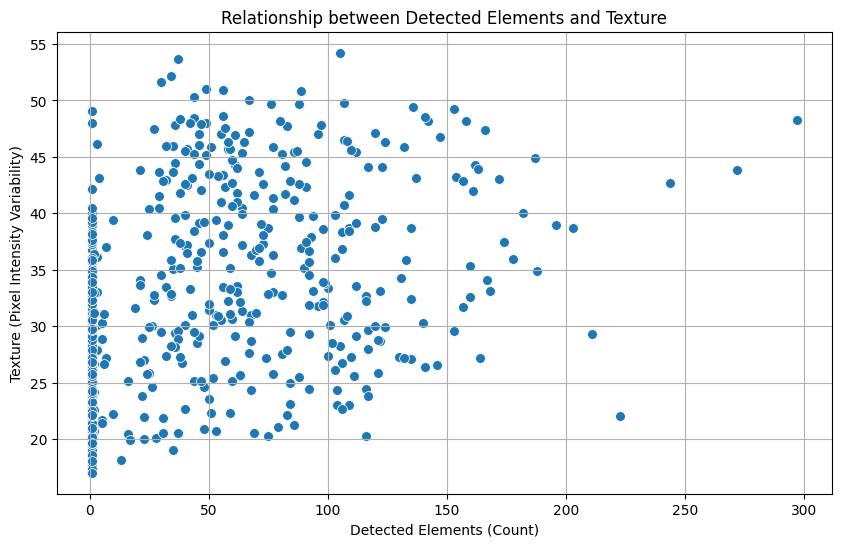

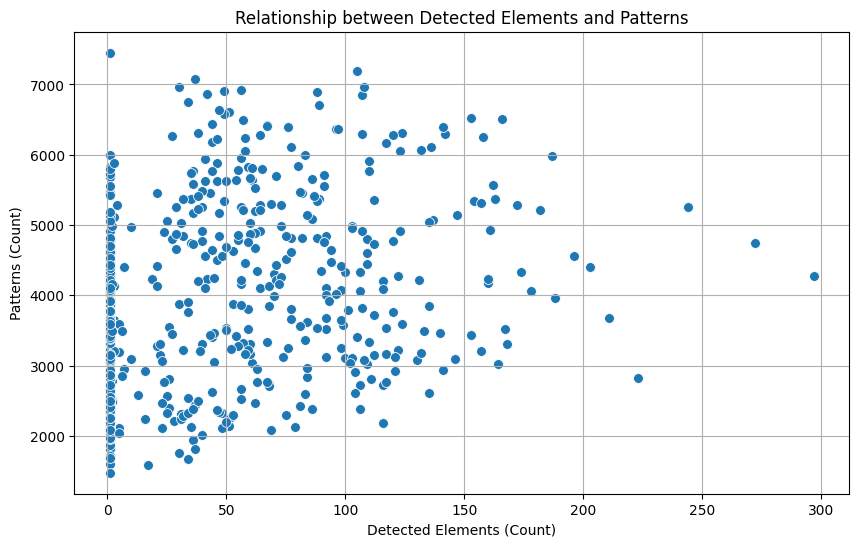

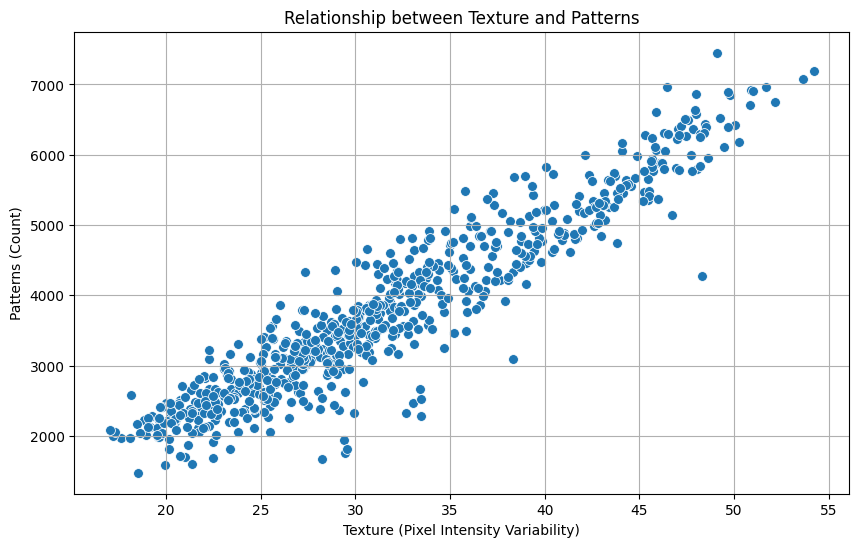

In [29]:
# Generate pairs of characteristics
pairs = itertools.combinations(characteristics_units.keys(), 2)

# Loop through each pair and create the relationship plots
for char1, char2 in pairs:
    plot_characteristic_relationship(
        df_stats,
        char1,
        char2,
        characteristics_units[char1],  # Get the unit for char1
        characteristics_units[char2]   # Get the unit for char2
    )

#### Heat Map

In [30]:
correlation_matrix = df_stats.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

ValueError: could not convert string to float: 'Image_1'

### Step 6: Perform statistical tests

In [ ]:
test_results_table = overall_statistical_tests(df_stats)
test_results_table

C:\Users\Shire\AppData\Local\Temp\ipykernel_16612\474161393.py:18: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_stat, corr_p_val = stats.pearsonr(df[char1], df[char2])


Test   Characteristic_1   Characteristic_2   Statistic  \
0             Normality         Brightness               None  512.223256   
1             Normality          Sharpness               None   94.519307   
2             Normality           Contrast               None   72.774737   
3   Pearson Correlation         Brightness          Sharpness   -0.086529   
4   Pearson Correlation         Brightness           Contrast    0.143239   
5   Pearson Correlation         Brightness              Noise   -0.068340   
6   Pearson Correlation         Brightness               Skew    0.047351   
7   Pearson Correlation         Brightness       Line Spacing   -0.007066   
8   Pearson Correlation         Brightness    Tables Detected    0.151732   
9   Pearson Correlation         Brightness         Resolution         NaN   
10  Pearson Correlation         Brightness  Detected Elements    0.377058   
11  Pearson Correlation         Brightness            Texture   -0.113539   
12  Pearson Correlation         Brightness           Patterns   -0.161545   
13  Pearson Correlation          Sharpness           Contrast    0.521191   
14  Pearson Correlation          Sharpness              Noise    0.991250   
15  Pearson Correlation          Sharpness               Skew    0.203159   
16  Pearson Correlation          Sharpness       Line Spacing   -0.008171   
17  Pearson Correlation          Sharpness    Tables Detected    0.151237   
18  Pearson Correlation          Sharpness         Resolution         NaN   
19  Pearson Correlation          Sharpness  Detected Elements    0.452302   
20  Pearson Correlation          Sharpness            Texture    0.990946   
21  Pearson Correlation          Sharpness           Patterns    0.941437   
22  Pearson Correlation           Contrast              Noise    0.559252   
23  Pearson Correlation           Contrast               Skew    0.178991   
24  Pearson Correlation           Contrast       Line Spacing   -0.031186   
25  Pearson Correlation           Contrast    Tables Detected   -0.082980   
26  Pearson Correlation           Contrast         Resolution         NaN   
27  Pearson Correlation           Contrast  Detected Elements    0.454411   
28  Pearson Correlation           Contrast            Texture    0.531012   
29  Pearson Correlation           Contrast           Patterns    0.338710   
30  Pearson Correlation              Noise               Skew    0.191861   
31  Pearson Correlation              Noise       Line Spacing   -0.006717   
32  Pearson Correlation              Noise    Tables Detected    0.140513   
33  Pearson Correlation              Noise         Resolution         NaN   
34  Pearson Correlation              Noise  Detected Elements    0.459237   
35  Pearson Correlation              Noise            Texture    0.986893   
36  Pearson Correlation              Noise           Patterns    0.921746   
37  Pearson Correlation               Skew       Line Spacing   -0.024086   
38  Pearson Correlation               Skew    Tables Detected    0.083409   
39  Pearson Correlation               Skew         Resolution         NaN   
40  Pearson Correlation               Skew  Detected Elements    0.200823   
41  Pearson Correlation               Skew            Texture    0.198209   
42  Pearson Correlation               Skew           Patterns    0.190604   
43  Pearson Correlation       Line Spacing    Tables Detected    0.028259   
44  Pearson Correlation       Line Spacing         Resolution         NaN   
45  Pearson Correlation       Line Spacing  Detected Elements   -0.073318   
46  Pearson Correlation       Line Spacing            Texture   -0.006125   
47  Pearson Correlation       Line Spacing           Patterns   -0.004738   
48  Pearson Correlation    Tables Detected         Resolution         NaN   
49  Pearson Correlation    Tables Detected  Detected Elements    0.118119   
50  Pearson Correlation    Tables Detected            Texture    0.146912   
51  Pearson Cor

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def highlight_brightness_popularity(images):
    """
    Generate a heatmap showing areas with higher or lower brightness popularity across multiple images.
    
    Parameters:
        images (list): List of grayscale images (2D numpy arrays).
        
    Returns:
        None: Displays the heatmap visualization.
    """
    if not images:
        raise ValueError("No images provided.")

    # Ensure all images have the same dimensions
    img_height, img_width = images[0].shape
    for image in images:
        if image.shape != (img_height, img_width):
            raise ValueError("All images must have the same dimensions.")

    # Initialize an accumulator for brightness values
    brightness_accumulator = np.zeros((img_height, img_width), dtype=np.float64)

    # Accumulate brightness values for each pixel across all images
    for image in images:
        brightness_accumulator += image.astype(np.float64)

    # Normalize the accumulated brightness to fall between 0 and 255
    brightness_heatmap = cv2.normalize(brightness_accumulator, None, 0, 255, cv2.NORM_MINMAX)

    # Plot the heatmap
    plt.figure(figsize=(6, 6))
    plt.title("Heatmap of Brightness Popularity Across Images")
    plt.imshow(brightness_heatmap, cmap='gray', interpolation='nearest')
    plt.colorbar(label='Brightness Popularity')
    plt.show()

# Example usage:
# Load your images as grayscale and pass them to the function
# images = [cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) for image_path in image_paths]
# highlight_brightness_popularity(images)


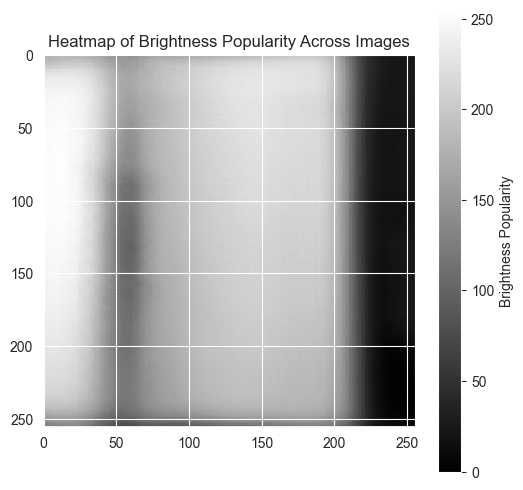

In [ ]:
highlight_brightness_popularity(images)

In [ ]:
# import os
# import cv2
# import matplotlib.pyplot as plt
# from tqdm import tqdm
# 
# # Function to load image paths with a loading bar
# def load_images_from_folder(folder_path, extensions=('.png', '.jpg', '.jpeg', '.JPG')):
#     """
#     Load all image file paths from a specified folder that match the given file extensions.
#     """
#     if not os.path.exists(folder_path):
#         raise FileNotFoundError(f"The specified folder does not exist: {folder_path}")
# 
#     # Use tqdm to show progress for collecting file paths
#     image_paths = [os.path.join(folder_path, f) for f in tqdm(os.listdir(folder_path),
#                                                               desc="Gathering image paths",
#                                                               unit="file")
#                    if f.endswith(extensions)]
#     return image_paths
# 
# # Function to load and preprocess images with a loading bar
# def load_and_preprocess_images(image_paths, resize_dim=(256, 256)):
#     images = []
#     for path in tqdm(image_paths, desc="Loading and preprocessing images", unit="image"):
#         img = cv2.imread(path)
#         img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#         img_resized = cv2.resize(img_gray, resize_dim)
#         images.append(img_resized)
#     return images
# 
# # Function to load original images with a loading bar
# def load_images(image_paths):
#     original_images = []
#     for path in tqdm(image_paths, desc="Loading original images", unit="image"):
#         img = cv2.imread(path)
# 
#         # Check if image was loaded correctly
#         if img is not None:
#             original_images.append(img)
#         else:
#             print(f"Warning: Unable to load image at {path}. Skipping.")
# 
#     return original_images[:10]  # Limit to the first 10 images to avoid memory issues
# 
# # Execution code
# # folder_path = '../data/original'
# image_paths = load_images_from_folder(folder_path)
# 
# # Load original and processed images
# original_images = load_images(image_paths)
# processed_images = load_and_preprocess_images(image_paths)


In [ ]:
# import matplotlib.pyplot as plt
# import cv2
# 
# # Display each pair of images separately
# num_images_to_show = min(3, len(original_images))  # Limit to the first 3 pairs
# 
# for i in range(num_images_to_show):
#     # Create a new figure for each pair
#     plt.figure(figsize=(6, 6))
# 
#     # Display Original Image
#     plt.subplot(2, 1, 1)
#     plt.imshow(cv2.cvtColor(original_images[i], cv2.COLOR_BGR2RGB))
#     plt.axis("off")
#     plt.title(f"Original Image {i + 1}")
# 
#     # Display Grayscale Processed Image
#     plt.subplot(2, 1, 2)
#     plt.imshow(processed_images[i], cmap="gray")
#     plt.axis("off")
#     plt.title(f"Grayscale Image {i + 1}")
# 
#     # Show each figure separately
#     plt.tight_layout()
#     plt.show()
